# Inspect the single-lineage model run on the prostate data

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from time import time

import arviz as az
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

In [3]:
from speclet.analysis.arviz_analysis import extract_coords_param_names
from speclet.bayesian_models.lineage_hierarchical_nb import LineageHierNegBinomModel
from speclet.data_processing.common import head_tail
from speclet.io import modeling_data_dir, models_dir
from speclet.managers.data_managers import CrisprScreenDataManager
from speclet.plot import set_speclet_theme

In [4]:
# Notebook execution timer.
notebook_tic = time()

# Plotting setup.
set_speclet_theme()
%config InlineBackend.figure_format = "retina"

## Data

### Load posterior summary

In [5]:
prostate_post_summary = pd.read_csv(
    models_dir() / "hnb-single-lineage-prostate_PYMC_NUMPYRO" / "posterior-summary.csv"
).assign(var_name=lambda d: [x.split("[")[0] for x in d["parameter"]])
prostate_post_summary.head()

parameter   mean     sd  hdi_5.5%  hdi_94.5%  mcse_mean  mcse_sd  \
0          alpha  8.219  0.021     8.182      8.251      0.000    0.000   
1        sigma_b  0.097  0.036     0.048      0.139      0.001    0.001   
2        sigma_f  0.039  0.014     0.020      0.055      0.000    0.000   
3  b[ACH-000115]  0.108  0.002     0.104      0.112      0.000    0.000   
4  b[ACH-000977]  0.085  0.002     0.081      0.089      0.000    0.000   

   ess_bulk  ess_tail  r_hat var_name  
0    4274.0    2931.0   1.00    alpha  
1     403.0     585.0   1.01  sigma_b  
2     789.0    1429.0   1.01  sigma_f  
3     438.0     755.0   1.01        b  
4     412.0     762.0   1.01        b

### Load trace object

In [6]:
trace_file = (
    models_dir() / "hnb-single-lineage-prostate_PYMC_NUMPYRO" / "posterior.netcdf"
)
assert trace_file.exists()
trace = az.from_netcdf(trace_file)

### Prostate data

In [7]:
def _broad_only(df: pd.DataFrame) -> pd.DataFrame:
    return df[df["screen"] == "broad"].reset_index(drop=True)


prostate_dm = CrisprScreenDataManager(
    modeling_data_dir() / "lineage-modeling-data" / "depmap-modeling-data_prostate.csv",
    transformations=[_broad_only],
)

In [8]:
prostate_data = prostate_dm.get_data(read_kwargs={"low_memory": False})
prostate_data.head()

sgrna                 replicate_id       lfc p_dna_batch  \
0  AAAGCCCAGGAGTATGGGAG  Vcap-304Cas9_RepA_p4_batch3  0.246450           3   
1  AAATCAGAGAAACCTGAACG  Vcap-304Cas9_RepA_p4_batch3  0.626518           3   
2  AACGTCTTTGAAGAAAGCTG  Vcap-304Cas9_RepA_p4_batch3  0.165114           3   
3  AACGTCTTTGAAGGAAGCTG  Vcap-304Cas9_RepA_p4_batch3 -0.094688           3   
4  AAGAGGTTCCAGACTACTTA  Vcap-304Cas9_RepA_p4_batch3  0.294496           3   

   genome_alignment hugo_symbol screen  multiple_hits_on_gene  \
0  chr2_130522105_-       CFC1B  broad                   True   
1  chr11_89916950_-    TRIM49D1  broad                   True   
2   chr5_71055421_-      GTF2H2  broad                   True   
3   chr5_69572480_+     GTF2H2C  broad                   True   
4  chrX_155898173_+       VAMP7  broad                   True   

  sgrna_target_chr  sgrna_target_pos  ... any_deleterious  any_tcga_hotspot  \
0                2         130522105  ...             NaN               NaN   
1               11          89916950  ...             NaN               NaN   
2                5          71055421  ...             NaN               NaN   
3                5          69572480  ...             NaN               NaN   
4                X         155898173  ...             NaN               NaN   

   any_cosmic_hotspot  is_mutated  copy_number   lineage  \
0                 NaN       False     0.999455  prostate   
1                 NaN       False     1.281907  prostate   
2                 NaN       False     0.616885  prostate   
3                 NaN       False     0.616885  prostate   
4                 NaN       False     0.615935  prostate   

           lineage_subtype primary_or_metastasis  is_male   age  
0  prostate_adenocarcinoma            metastasis     True  59.0  
1  prostate_adenocarcinoma            metastasis     True  59.0  
2  prostate_adenocarcinoma            metastasis     True  59.0  
3  prostate_adenocarcinoma            metastasis     True  59.0  
4  prostate_adenocarcinoma            metastasis     True  59.0  

[5 rows x 25 columns]

### Single lineage model

In [9]:
prostate_model = LineageHierNegBinomModel(lineage="prostate")

In [10]:
valid_prostate_data = prostate_model.data_processing_pipeline(prostate_data.copy())
prostate_mdl_data = prostate_model.make_data_structure(valid_prostate_data)

[07/21/22 03:48:24] INFO     Processing data for modeling.     ]8;id=971988;file:///n/data1/hms/dbmi/park/Cook/speclet/speclet/bayesian_models/lineage_hierarchical_nb.py\lineage_hierarchical_nb.py]8;;\:]8;id=90000;file:///n/data1/hms/dbmi/park/Cook/speclet/speclet/bayesian_models/lineage_hierarchical_nb.py#268\268]8;;\

                    INFO     LFC limits: (-5.0, 5.0)           ]8;id=247114;file:///n/data1/hms/dbmi/park/Cook/speclet/speclet/bayesian_models/lineage_hierarchical_nb.py\lineage_hierarchical_nb.py]8;;\:]8;id=363880;file:///n/data1/hms/dbmi/park/Cook/speclet/speclet/bayesian_models/lineage_hierarchical_nb.py#269\269]8;;\

[07/21/22 03:49:36] WARNING  number of data points dropped: 2  ]8;id=593955;file:///n/data1/hms/dbmi/park/Cook/speclet/speclet/bayesian_models/lineage_hierarchical_nb.py\lineage_hierarchical_nb.py]8;;\:]8;id=945466;file:///n/data1/hms/dbmi/park/Cook/speclet/speclet/bayesian_models/lineage_hierarchical_nb.py#313\313]8;;\

## Analysis

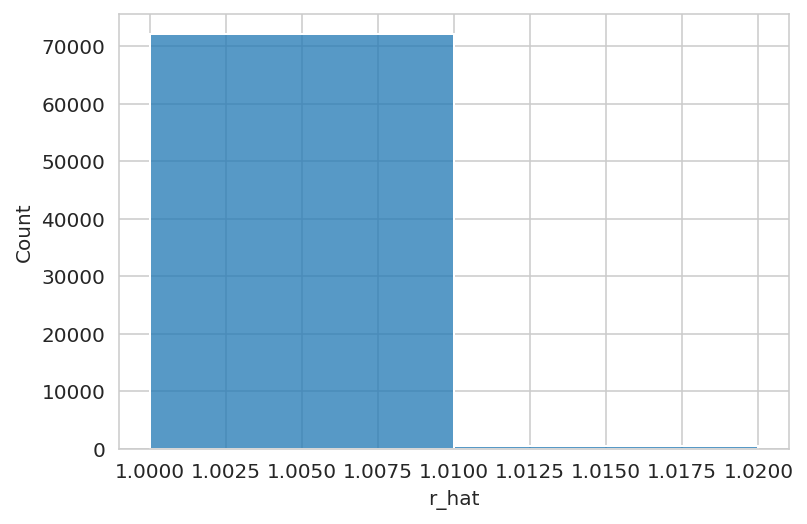

In [11]:
sns.histplot(x=prostate_post_summary["r_hat"], binwidth=0.01);

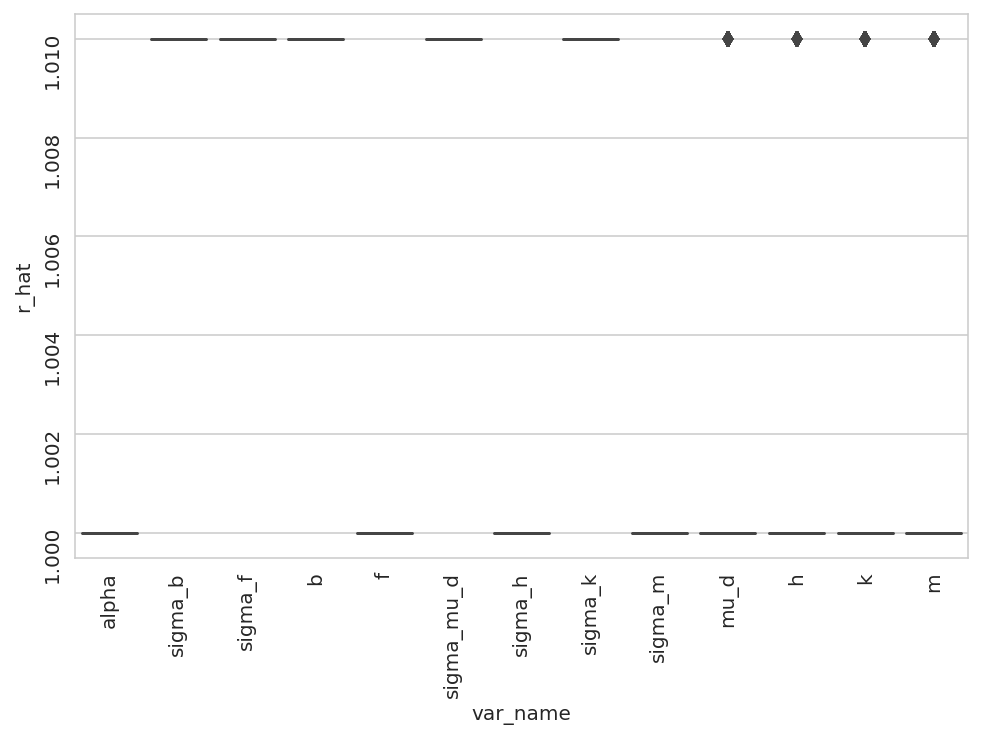

In [12]:
fig, ax = plt.subplots(figsize=(8, 5))
sns.boxplot(data=prostate_post_summary, x="var_name", y="r_hat", ax=ax)
ax.tick_params(rotation=90)
plt.show()

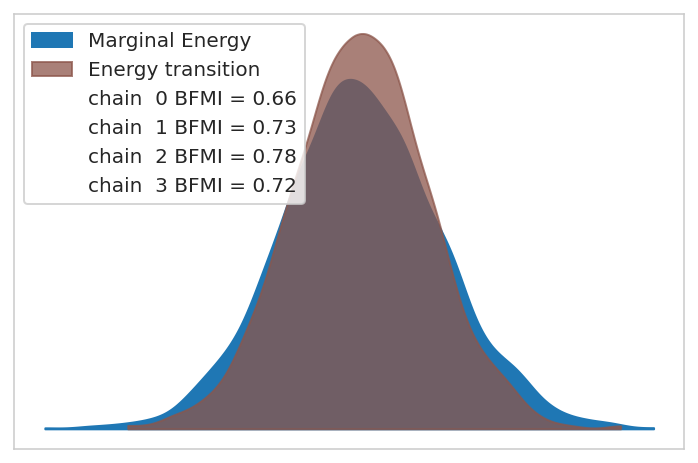

In [13]:
az.plot_energy(trace);

In [14]:
sgrna_to_gene_map = (
    prostate_data.copy()[["hugo_symbol", "sgrna"]]
    .drop_duplicates()
    .reset_index(drop=True)
)

The posteriors for the varying sgRNA effect $d$ are far more variable than $\mu_d$ which basically collapsed to 0.

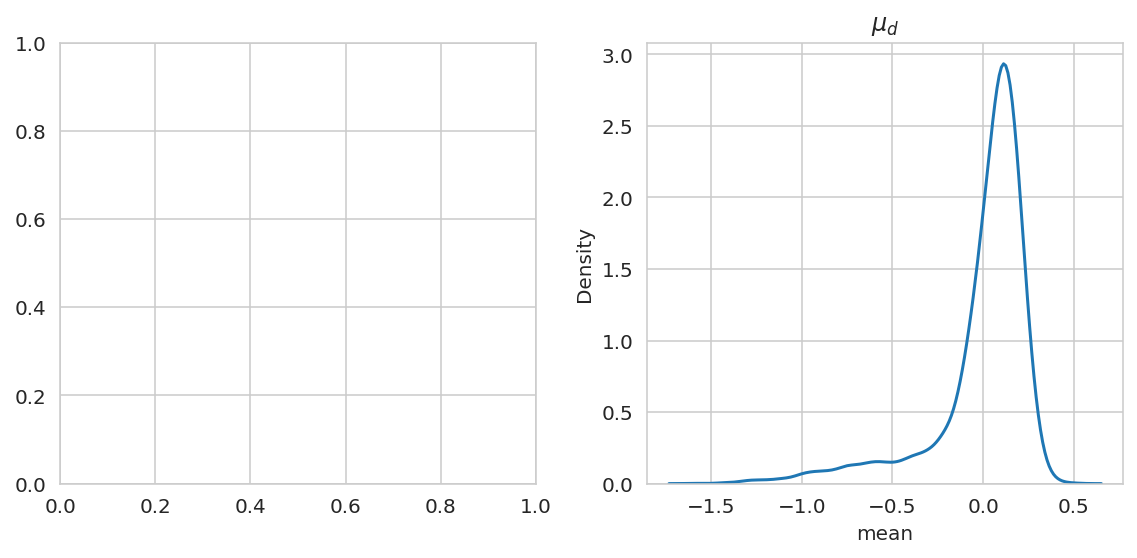

In [15]:
# d_post = (
#     prostate_post_summary.query("var_name == 'd'")
#     .reset_index(drop=True)
#     .pipe(extract_coords_param_names, names=["sgrna"], col="parameter")
#     .merge(sgrna_to_gene_map, on="sgrna", how="left")
# )

mu_d_post = (
    prostate_post_summary.query("var_name == 'mu_d'")
    .reset_index(drop=True)
    .pipe(extract_coords_param_names, names=["hugo_symbol"], col="parameter")
)

fig, axes = plt.subplots(ncols=2, figsize=(8, 4))

# sns.kdeplot(d_post["mean"], ax=axes[0])
# axes[0].set_title(r"$d$")

sns.kdeplot(mu_d_post["mean"], ax=axes[1])
axes[1].set_title(r"$\mu_d$")

plt.tight_layout()
plt.show()

In [16]:
(
    prostate_post_summary.query("var_name == 'mu_d'")
    .sort_values("mean")
    .reset_index(drop=True)
    .pipe(head_tail, n=10)
)

parameter   mean     sd  hdi_5.5%  hdi_94.5%  mcse_mean  mcse_sd  \
0            mu_d[RAN] -1.617  0.083    -1.747     -1.482      0.001    0.001   
1          mu_d[HSPE1] -1.583  0.078    -1.703     -1.458      0.001    0.001   
2          mu_d[KIF11] -1.581  0.083    -1.711     -1.444      0.001    0.001   
3          mu_d[RPL12] -1.527  0.086    -1.666     -1.396      0.001    0.001   
4           mu_d[RPL9] -1.457  0.081    -1.586     -1.328      0.001    0.001   
5           mu_d[EEF2] -1.447  0.083    -1.580     -1.310      0.001    0.001   
6          mu_d[RPS28] -1.446  0.083    -1.579     -1.315      0.001    0.001   
7         mu_d[CHAF1B] -1.445  0.084    -1.585     -1.312      0.001    0.001   
8         mu_d[POLR2L] -1.440  0.084    -1.586     -1.315      0.001    0.001   
9           mu_d[DUX4] -1.436  0.079    -1.561     -1.310      0.001    0.001   
18109      mu_d[FOPNL]  0.442  0.075     0.322      0.558      0.001    0.001   
18110      mu_d[MGST1]  0.445  0.076     0.318      0.560      0.001    0.001   
18111   mu_d[KRTAP1-3]  0.449  0.130     0.246      0.655      0.002    0.001   
18112  mu_d[TMPRSS11F]  0.458  0.086     0.321      0.594      0.001    0.001   
18113      mu_d[EPHA2]  0.474  0.076     0.355      0.593      0.001    0.001   
18114   mu_d[HLA-DQB1]  0.481  0.084     0.348      0.613      0.001    0.001   
18115        mu_d[NF2]  0.502  0.073     0.390      0.624      0.001    0.001   
18116      mu_d[CDH15]  0.505  0.075     0.389      0.631      0.001    0.001   
18117     mu_d[ZNF611]  0.516  0.074     0.399      0.637      0.001    0.001   
18118   mu_d[HIST1H4I]  0.537  0.073     0.417      0.649      0.001    0.001   

       ess_bulk  ess_tail  r_hat var_name  
0        6117.0    2547.0    1.0     mu_d  
1        6065.0    2672.0    1.0     mu_d  
2        6451.0    3028.0    1.0     mu_d  
3        5849.0    2787.0    1.0     mu_d  
4        5898.0    2788.0    1.0     mu_d  
5        5893.0    3062.0    1.0     mu_d  
6        5501.0    2896.0    1.0     mu_d  
7        6353.0    2564.0    1.0     mu_d  
8        6257.0    3275.0    1.0     mu_d  
9        5375.0    3184.0    1.0     mu_d  
18109    6048.0    2509.0    1.0     mu_d  
18110    6065.0    2701.0    1.0     mu_d  
18111    6325.0    2922.0    1.0     mu_d  
18112    5408.0    2861.0    1.0     mu_d  
18113    5437.0    3039.0    1.0     mu_d  
18114    6331.0    2807.0    1.0     mu_d  
18115    5927.0    2801.0    1.0     mu_d  
18116    5123.0    2501.0    1.0     mu_d  
18117    4973.0    2863.0    1.0     mu_d  
18118    6245.0    3149.0    1.0     mu_d

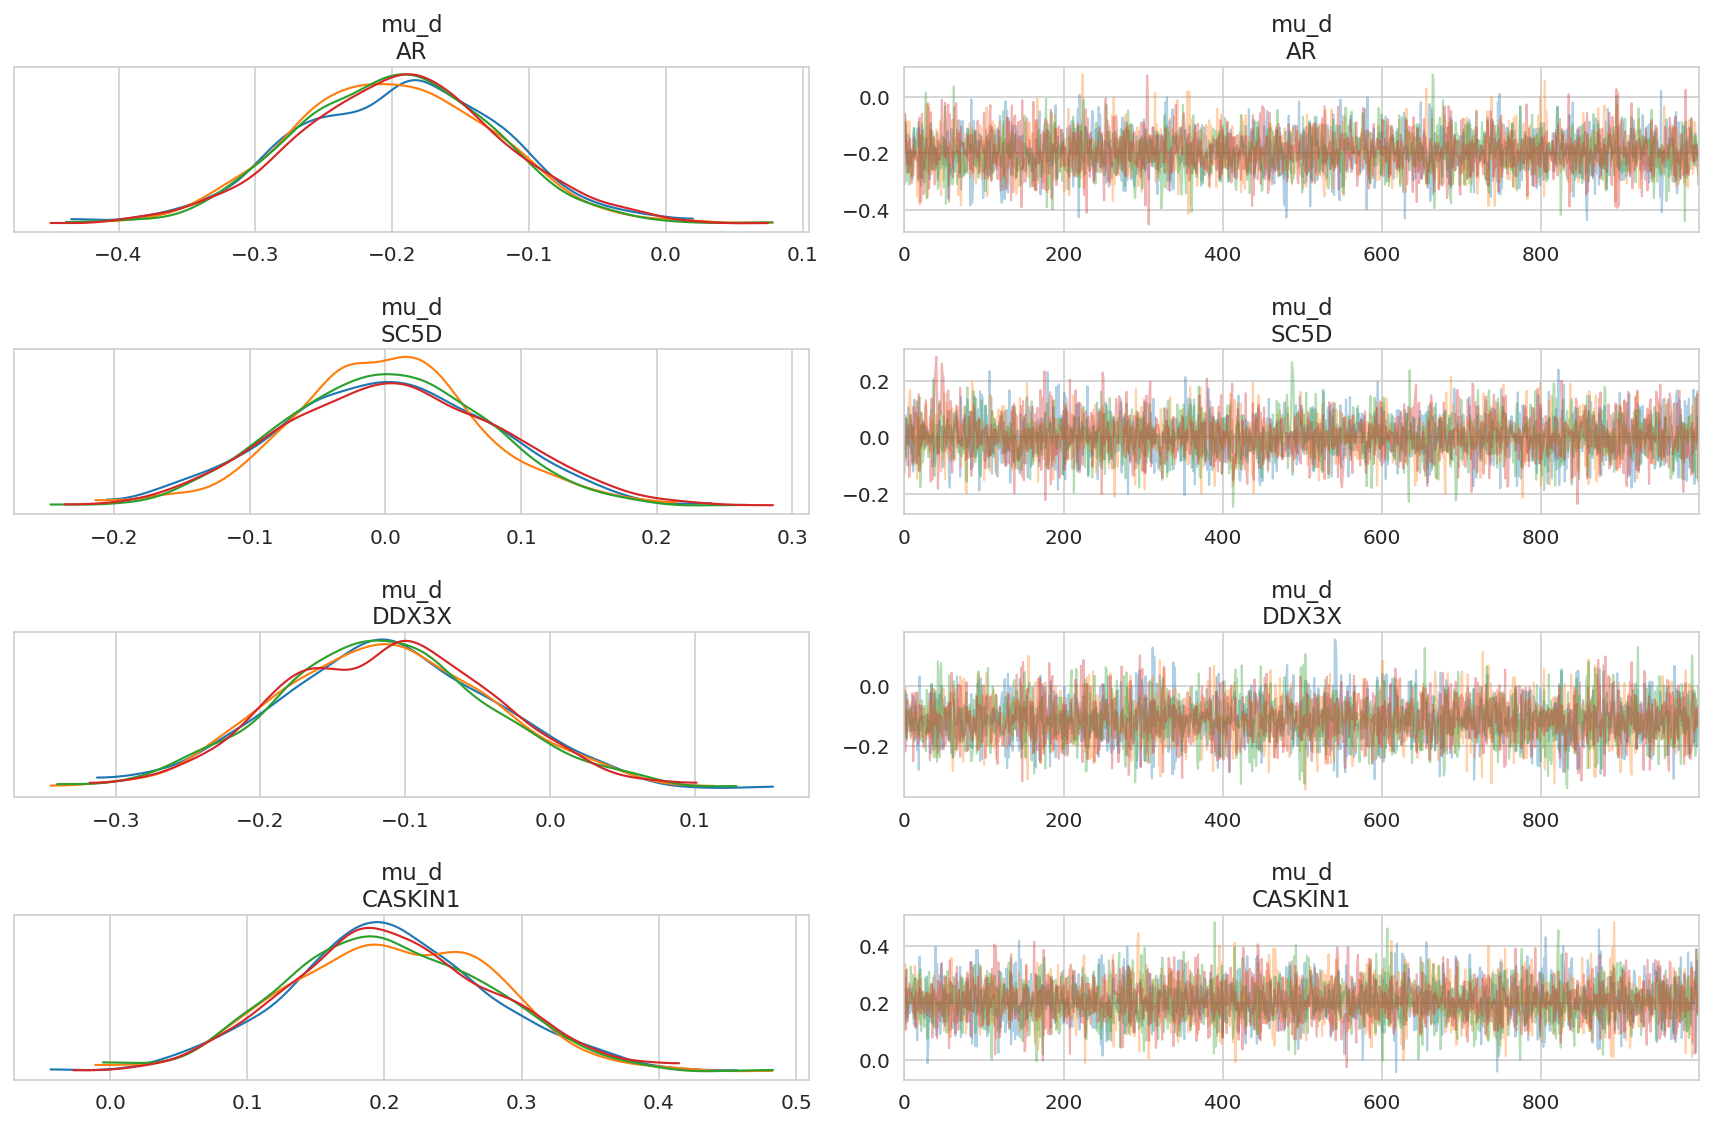

In [17]:
example_genes = ["AR", "SC5D", "DDX3X", "CASKIN1"]
az.plot_trace(trace, var_names="mu_d", coords={"gene": example_genes}, compact=False)
plt.tight_layout()
plt.show()

In [18]:
# sgrnas_sample = trace.posterior.coords["sgrna"].values[:5]

# az.plot_trace(trace, var_names="d", coords={"sgrna": sgrnas_sample}, compact=False)
# plt.tight_layout()
# plt.show()

The averages of the sgRNA posteriors for each gene have variability that never made it to $\mu_d$.

In [19]:
# d_post.groupby("hugo_symbol")[["mean", "hdi_5.5%", "hdi_94.5%"]].mean().reset_index(
#     drop=False
# ).head()

In [20]:
mu_d_post.query("hugo_symbol == 'A1BG'")

parameter  mean     sd  hdi_5.5%  hdi_94.5%  mcse_mean  mcse_sd  ess_bulk  \
0  mu_d[A1BG]   0.2  0.075     0.077      0.315      0.001    0.001    6384.0   

   ess_tail  r_hat var_name hugo_symbol  
0    2881.0    1.0     mu_d        A1BG

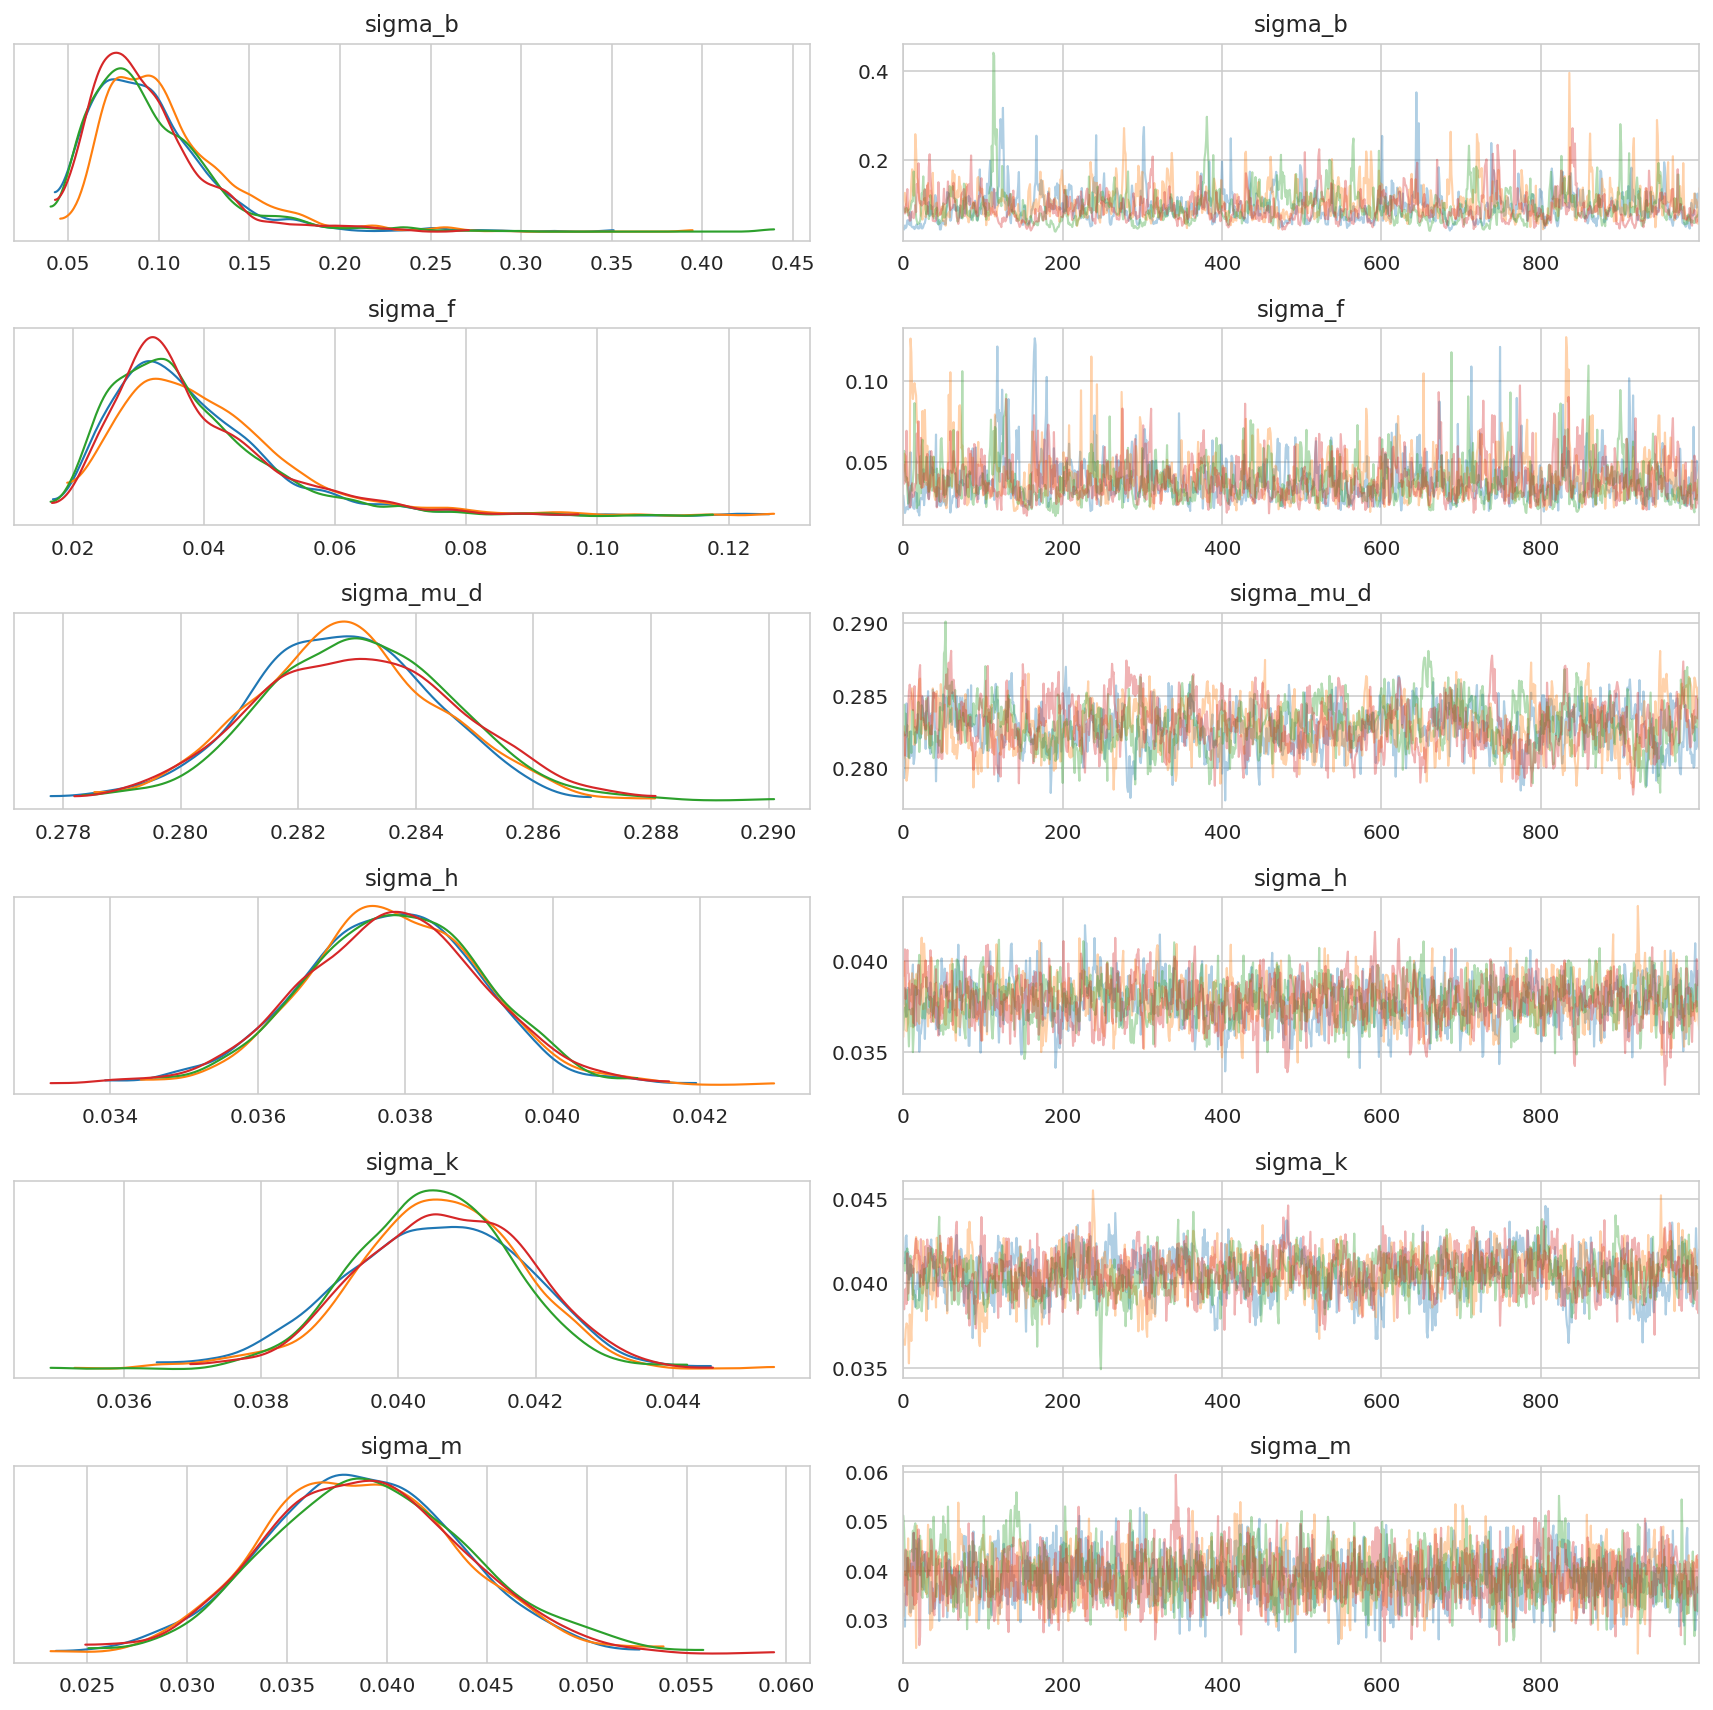

In [21]:
az.plot_trace(trace, var_names=["^sigma_*"], filter_vars="regex", compact=False)
plt.tight_layout()

In [22]:
prostate_post_summary.filter_string("var_name", "^sigma_*")

parameter   mean     sd  hdi_5.5%  hdi_94.5%  mcse_mean  mcse_sd  \
1      sigma_b  0.097  0.036     0.048      0.139      0.001    0.001   
2      sigma_f  0.039  0.014     0.020      0.055      0.000    0.000   
13  sigma_mu_d  0.283  0.002     0.281      0.286      0.000    0.000   
14     sigma_h  0.038  0.001     0.036      0.040      0.000    0.000   
15     sigma_k  0.041  0.001     0.039      0.043      0.000    0.000   
16     sigma_m  0.039  0.005     0.031      0.047      0.000    0.000   

    ess_bulk  ess_tail  r_hat    var_name  
1      403.0     585.0   1.01     sigma_b  
2      789.0    1429.0   1.01     sigma_f  
13     505.0    1091.0   1.01  sigma_mu_d  
14    1070.0    1858.0   1.00     sigma_h  
15     599.0    1028.0   1.01     sigma_k  
16    1296.0    1689.0   1.00     sigma_m

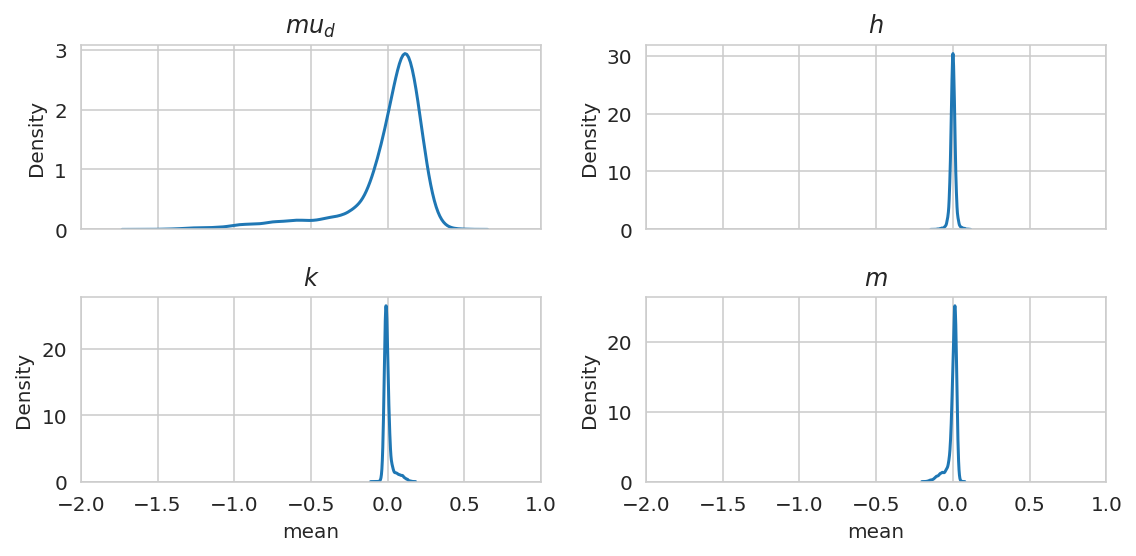

In [23]:
var_names = ["mu_d", "h", "k", "m"]
_, axes = plt.subplots(2, 2, figsize=(8, 4), sharex=True)
for ax, var_name in zip(axes.flatten(), var_names):
    x = prostate_post_summary.query(f"var_name == '{var_name}'")["mean"]
    sns.kdeplot(x=x, ax=ax)
    ax.set_title(f"${var_name}$")
    ax.set_xlim(-2, 1)

plt.tight_layout()
plt.show()

I wanted to briefly see if the sgRNA-to-gene indexing is incorrect, but everything seems fine.

In [24]:
# gene = "A1BG"
# gene_codes = valid_prostate_data["hugo_symbol"][
#     valid_prostate_data["hugo_symbol"] == gene
# ].cat.codes.unique()
# assert len(gene_codes) == 1
# gene_code = gene_codes[0]
# assert trace.posterior.coords["gene"][gene_code].values == gene

# sgrna_idx = np.where(prostate_mdl_data.sgrna_to_gene_idx == gene_code)
# sgrnas = trace.posterior.coords["sgrna"][sgrna_idx].values
# sgrna_to_gene_map.filter_column_isin("sgrna", sgrnas)

In [25]:
len(prostate_mdl_data.sgrna_to_gene_idx), len(set(prostate_mdl_data.sgrna_to_gene_idx))

(71062, 18119)

The trace for $b$ is highly autocorrelated.
It's very obvious when compared to the trace of $f$.

In [26]:
prostate_post_summary.filter_column_isin("var_name", ["sigma_b", "b", "sigma_f", "f"])

parameter   mean     sd  hdi_5.5%  hdi_94.5%  mcse_mean  mcse_sd  \
1         sigma_b  0.097  0.036     0.048      0.139      0.001    0.001   
2         sigma_f  0.039  0.014     0.020      0.055      0.000    0.000   
3   b[ACH-000115]  0.108  0.002     0.104      0.112      0.000    0.000   
4   b[ACH-000977]  0.085  0.002     0.081      0.089      0.000    0.000   
5   b[ACH-001453]  0.086  0.002     0.082      0.090      0.000    0.000   
6   b[ACH-001627]  0.069  0.003     0.065      0.073      0.000    0.000   
7   b[ACH-001648]  0.099  0.003     0.095      0.103      0.000    0.000   
8   f[ACH-000115] -0.044  0.002    -0.047     -0.041      0.000    0.000   
9   f[ACH-000977] -0.048  0.002    -0.051     -0.046      0.000    0.000   
10  f[ACH-001453] -0.030  0.002    -0.032     -0.027      0.000    0.000   
11  f[ACH-001627] -0.029  0.002    -0.031     -0.026      0.000    0.000   
12  f[ACH-001648] -0.024  0.002    -0.026     -0.021      0.000    0.000   

    ess_bulk  ess_tail  r_hat var_name  
1      403.0     585.0   1.01  sigma_b  
2      789.0    1429.0   1.01  sigma_f  
3      438.0     755.0   1.01        b  
4      412.0     762.0   1.01        b  
5      418.0     729.0   1.01        b  
6      416.0     668.0   1.01        b  
7      424.0     803.0   1.01        b  
8     4021.0    3812.0   1.00        f  
9     3521.0    3485.0   1.00        f  
10    3662.0    3420.0   1.00        f  
11    3018.0    2784.0   1.00        f  
12    3438.0    3140.0   1.00        f

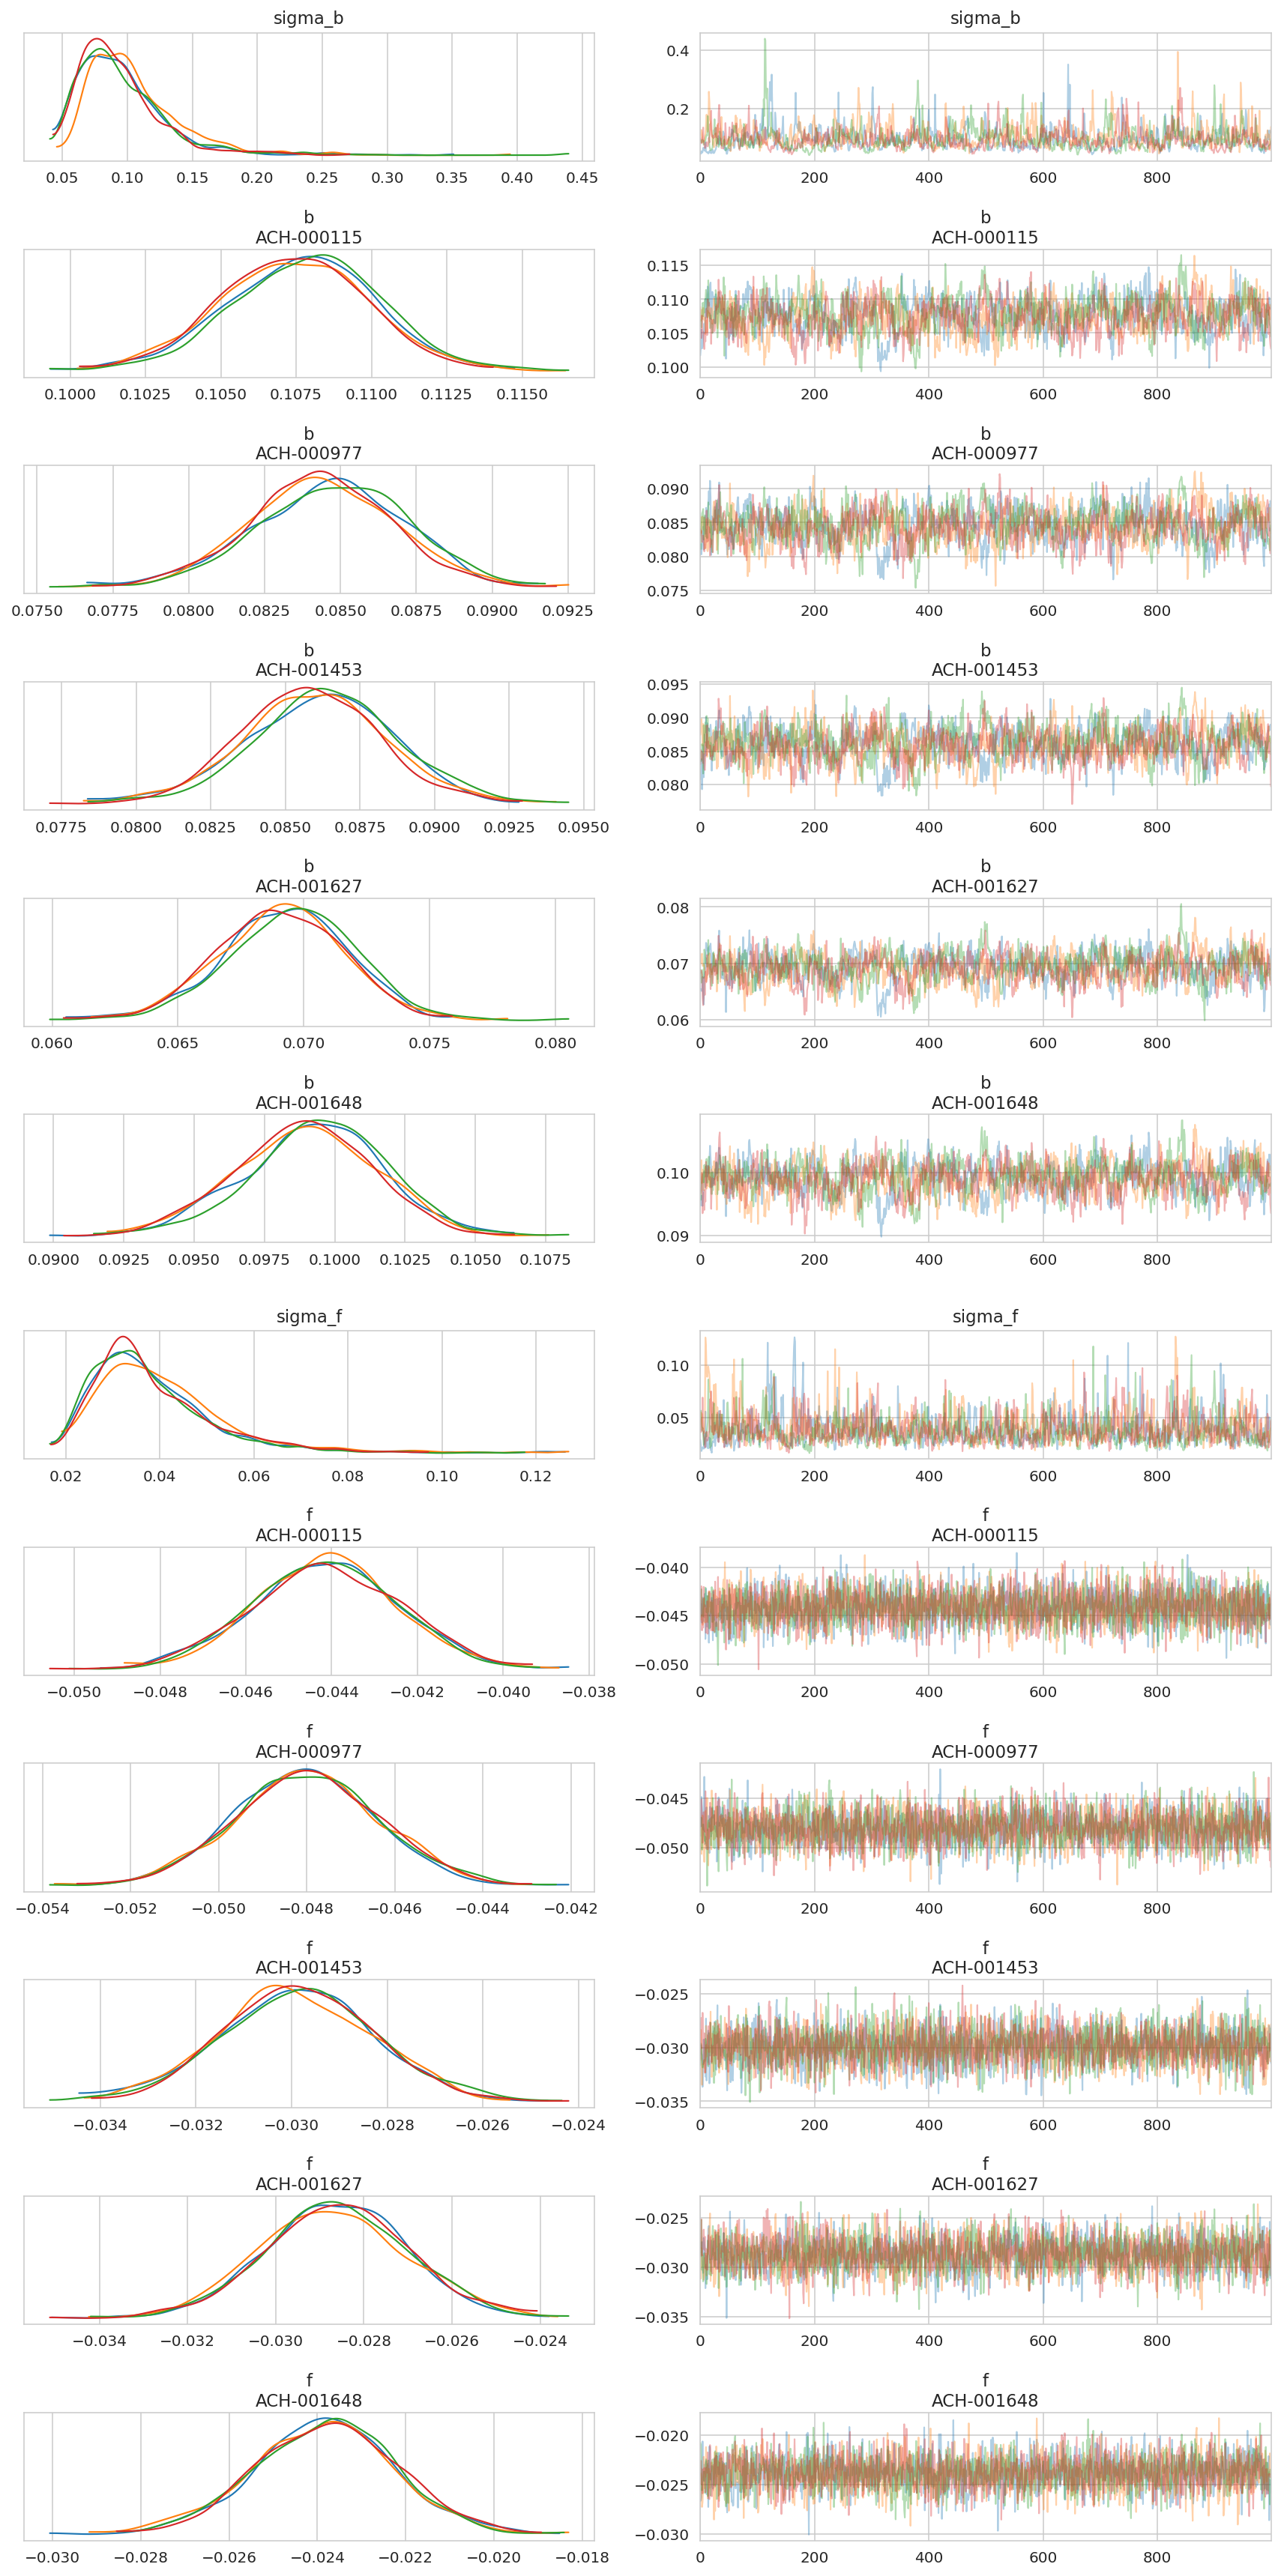

In [27]:
az.plot_trace(trace, var_names=["sigma_b", "b", "sigma_f", "f"], compact=False)
plt.tight_layout()
plt.show()

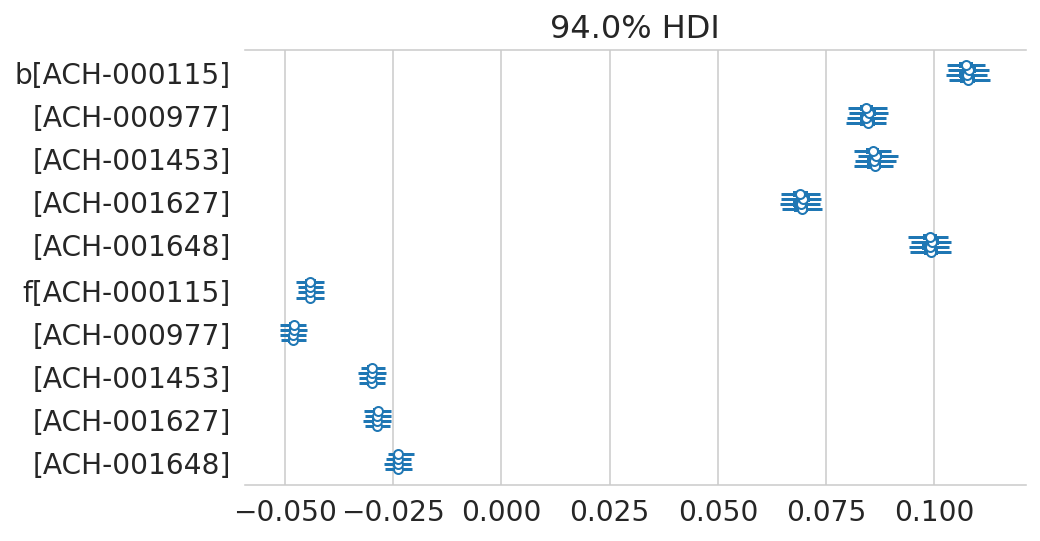

In [28]:
az.plot_forest(trace, var_names=["b", "f"], figsize=(7, 4));

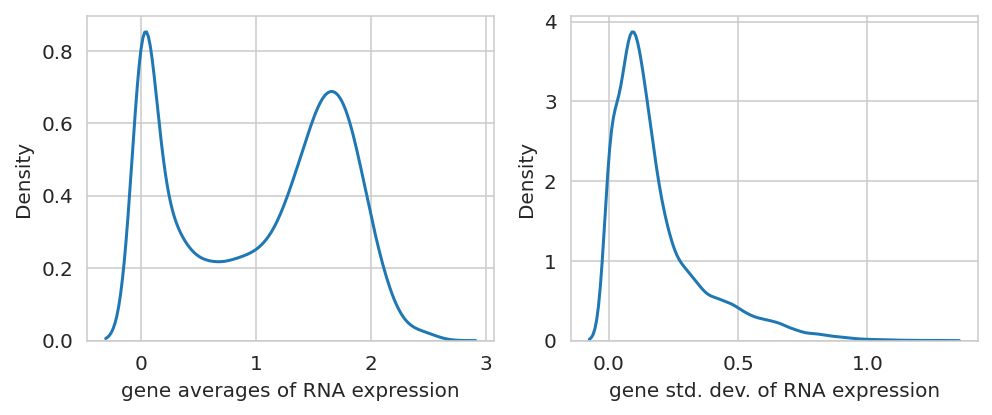

In [36]:
_, axes = plt.subplots(1, 2, figsize=(7, 3))
sns.kdeplot(
    valid_prostate_data.groupby("hugo_symbol")["log_rna_expr"].mean(), ax=axes[0]
)
sns.kdeplot(
    valid_prostate_data.groupby("hugo_symbol")["log_rna_expr"].std(), ax=axes[1]
)
axes[0].set_xlabel("gene averages of RNA expression")
axes[1].set_xlabel("gene std. dev. of RNA expression")
plt.tight_layout()
plt.show()

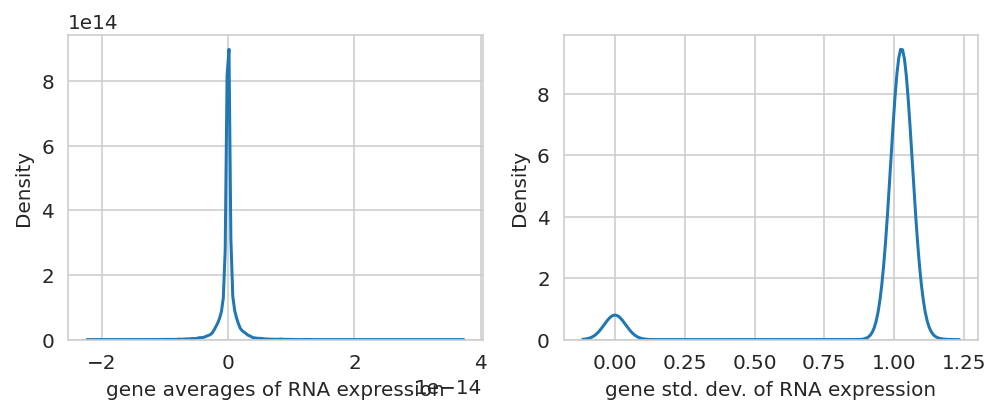

In [37]:
_, axes = plt.subplots(1, 2, figsize=(7, 3))
sns.kdeplot(
    valid_prostate_data.groupby("hugo_symbol")["z_log_rna_gene"].mean(), ax=axes[0]
)
sns.kdeplot(
    valid_prostate_data.groupby("hugo_symbol")["z_log_rna_gene"].std(), ax=axes[1]
)
axes[0].set_xlabel("gene averages of RNA expression")
axes[1].set_xlabel("gene std. dev. of RNA expression")
plt.tight_layout()
plt.show()

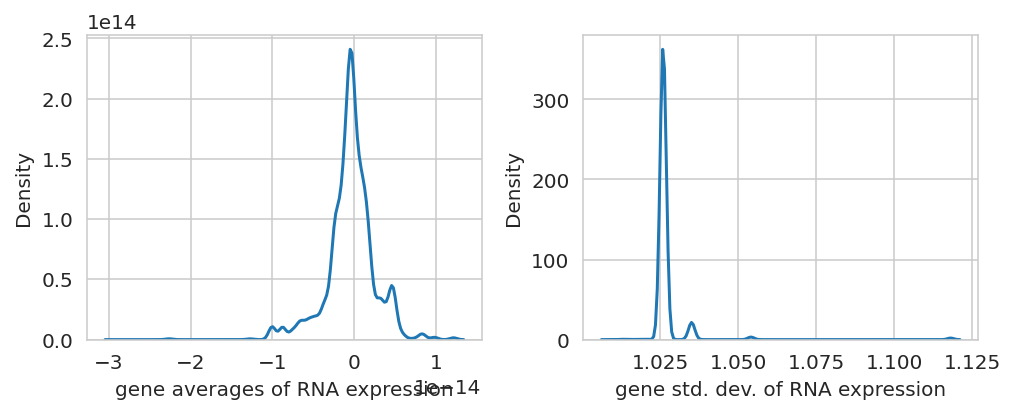

In [38]:
_, axes = plt.subplots(1, 2, figsize=(7, 3))
sns.kdeplot(valid_prostate_data.groupby("hugo_symbol")["z_cn_gene"].mean(), ax=axes[0])
sns.kdeplot(valid_prostate_data.groupby("hugo_symbol")["z_cn_gene"].std(), ax=axes[1])
axes[0].set_xlabel("gene averages of RNA expression")
axes[1].set_xlabel("gene std. dev. of RNA expression")
plt.tight_layout()
plt.show()

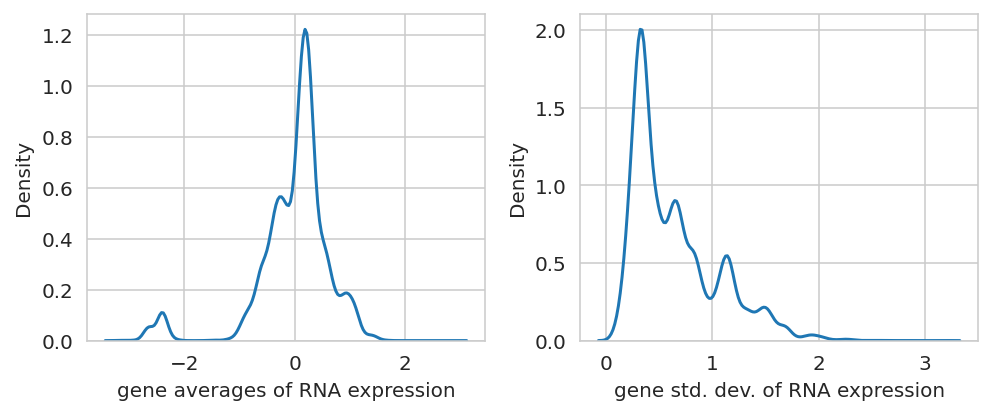

In [39]:
_, axes = plt.subplots(1, 2, figsize=(7, 3))
sns.kdeplot(
    valid_prostate_data.groupby("hugo_symbol")["z_cn_cell_line"].mean(), ax=axes[0]
)
sns.kdeplot(
    valid_prostate_data.groupby("hugo_symbol")["z_cn_cell_line"].std(), ax=axes[1]
)
axes[0].set_xlabel("gene averages of RNA expression")
axes[1].set_xlabel("gene std. dev. of RNA expression")
plt.tight_layout()
plt.show()

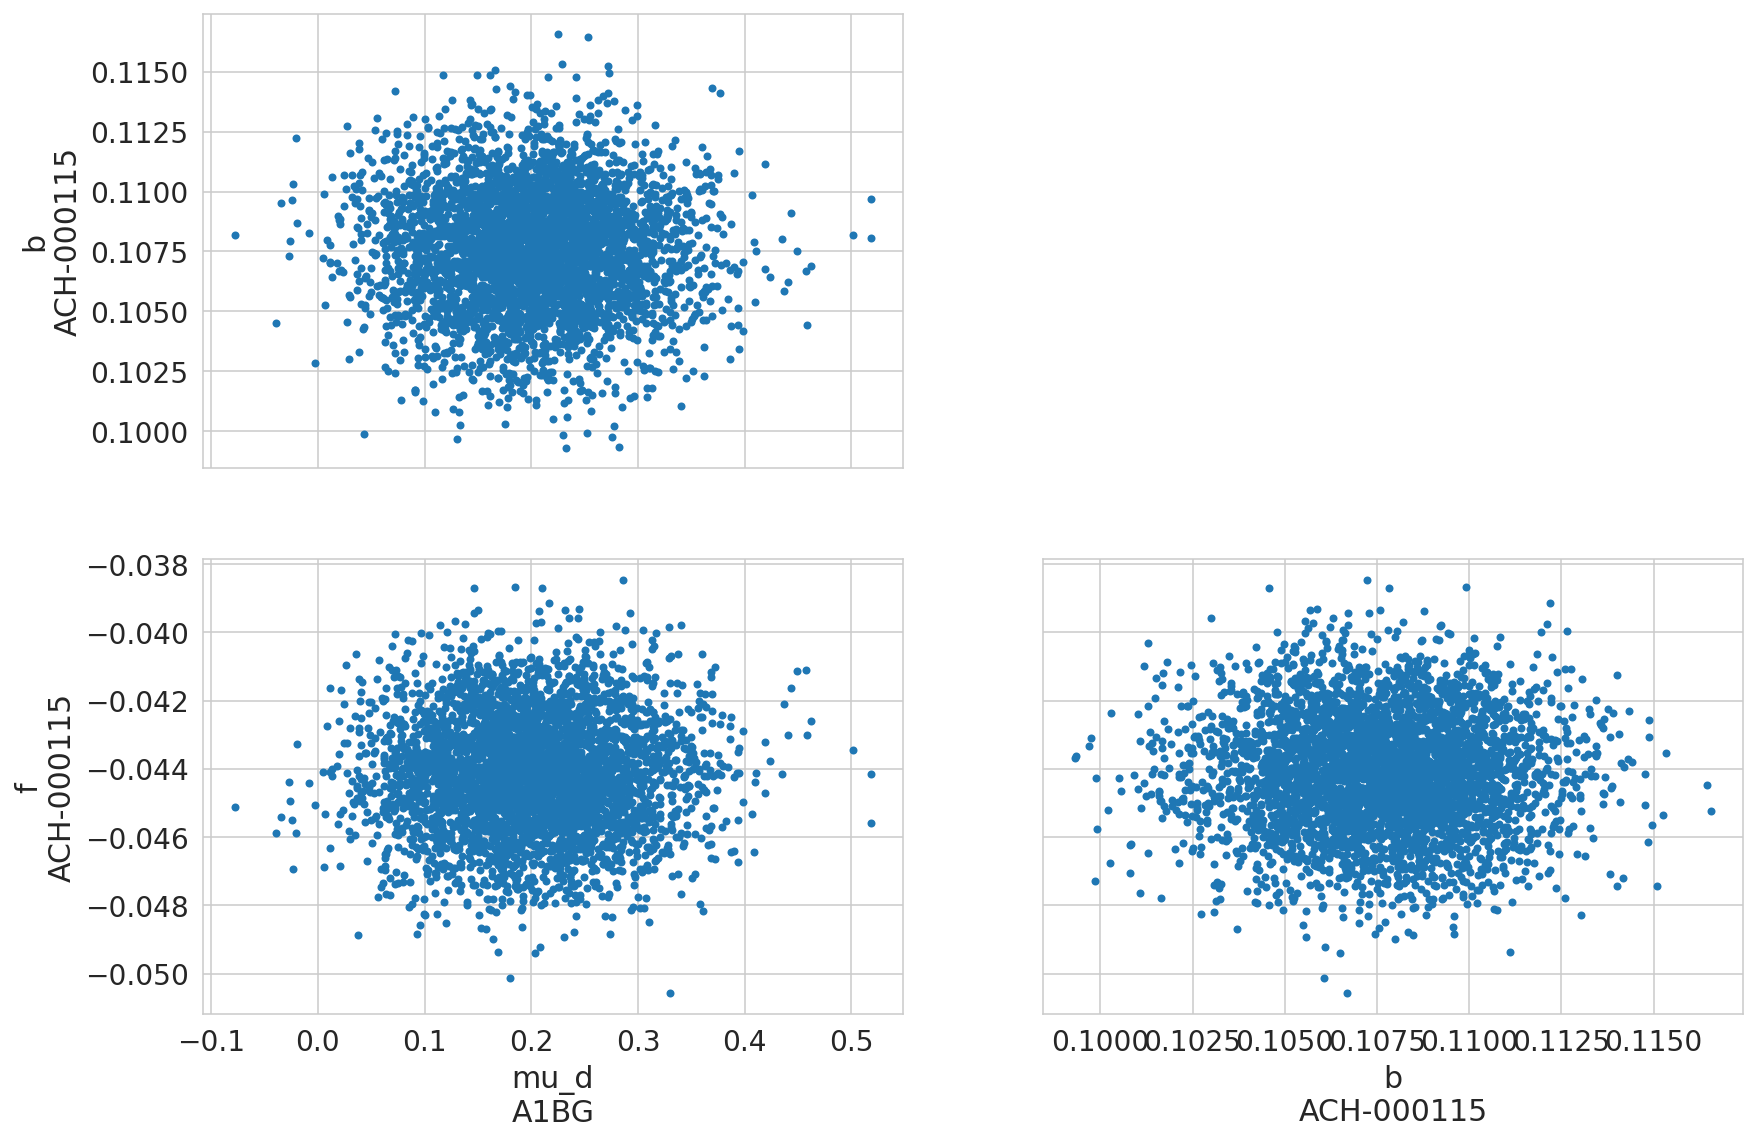

In [29]:
eg_gene = trace.posterior.coords["gene"].values[0]
eg_cell_line = trace.posterior.coords["cell_line"].values[0]

az.plot_pair(
    trace,
    var_names=["mu_d", "b", "f"],
    coords={"gene": [eg_gene], "cell_line": [eg_cell_line]},
);

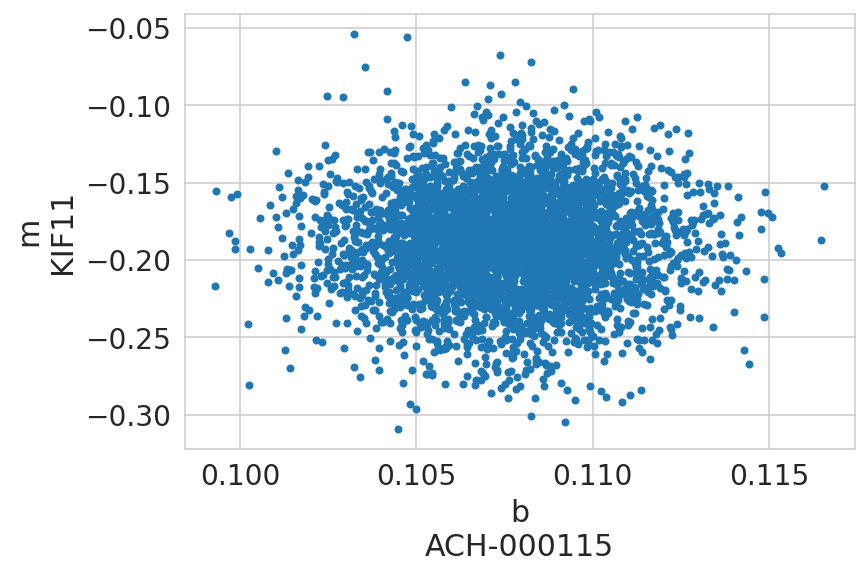

In [30]:
az.plot_pair(
    trace, var_names=["b", "m"], coords={"cell_line": [eg_cell_line], "gene": ["KIF11"]}
);

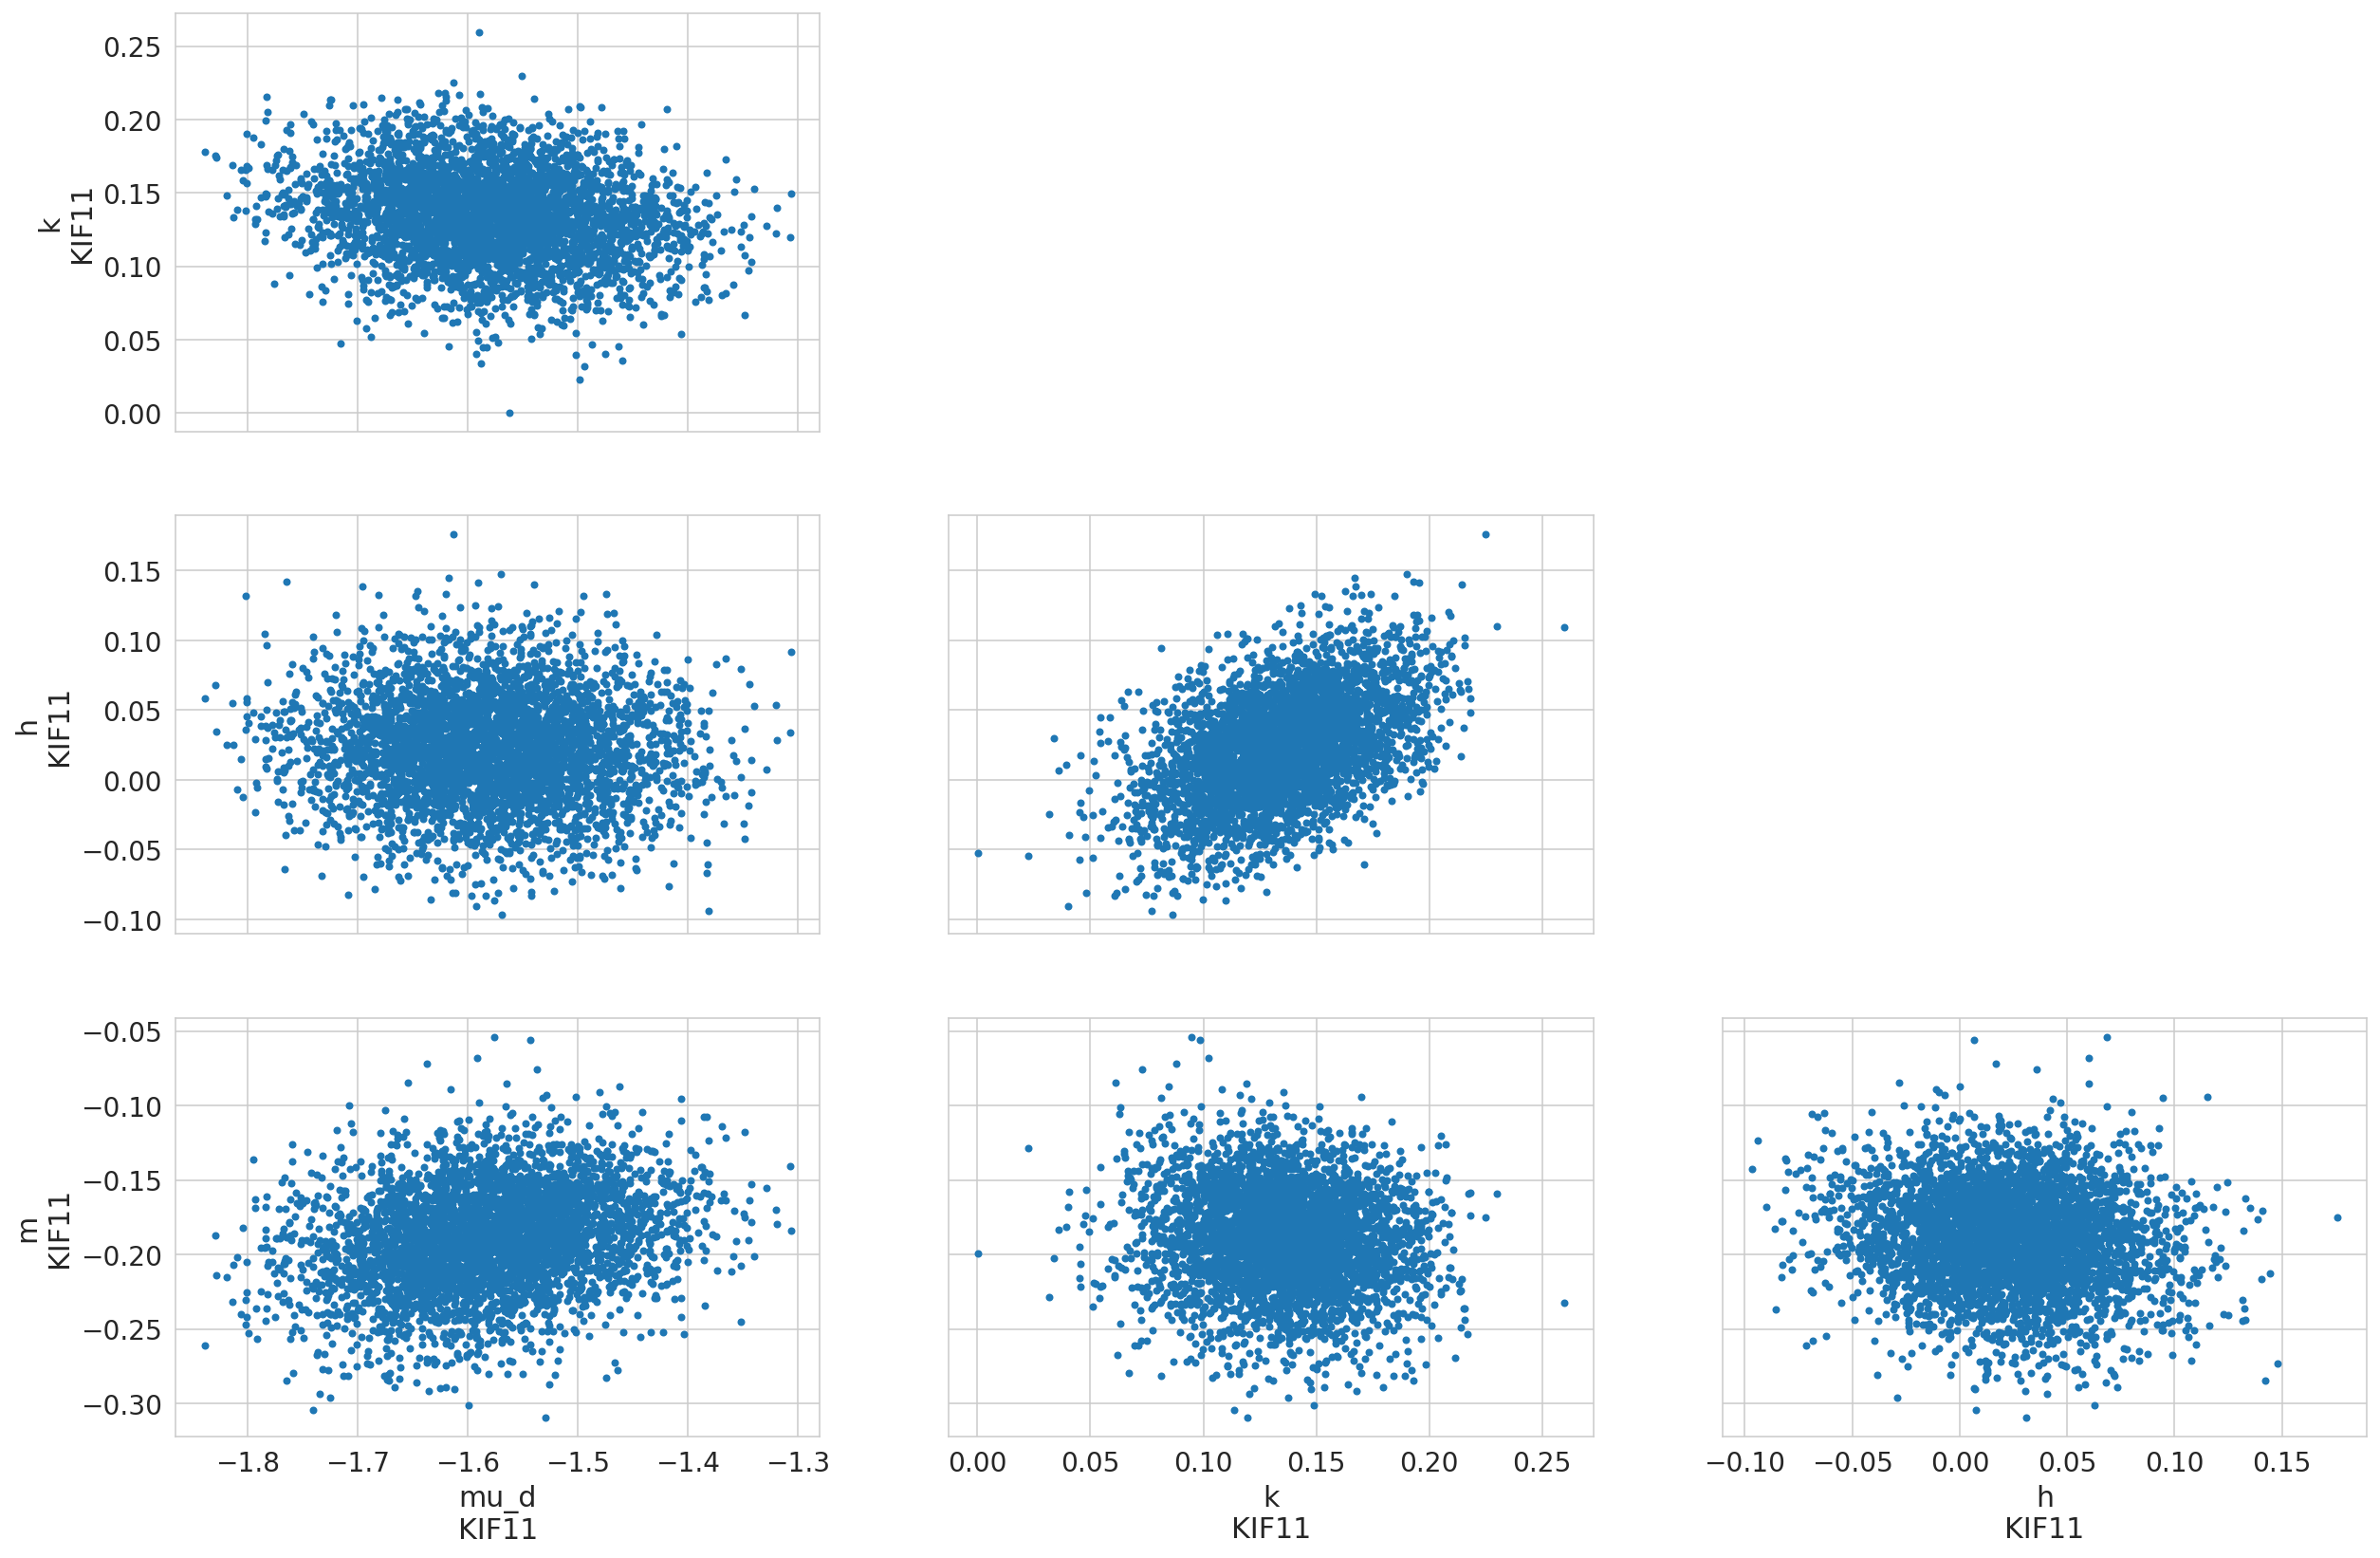

In [31]:
az.plot_pair(trace, var_names=["mu_d", "k", "h", "m"], coords={"gene": ["KIF11"]});

In [35]:
valid_prostate_data.columns

Index(['sgrna', 'replicate_id', 'lfc', 'p_dna_batch', 'genome_alignment',
       'hugo_symbol', 'screen', 'multiple_hits_on_gene', 'sgrna_target_chr',
       'sgrna_target_pos', 'depmap_id', 'counts_final', 'counts_initial',
       'rna_expr', 'num_mutations', 'any_deleterious', 'any_tcga_hotspot',
       'any_cosmic_hotspot', 'is_mutated', 'copy_number', 'lineage',
       'lineage_subtype', 'primary_or_metastasis', 'is_male', 'age',
       'z_rna_gene', 'z_cn_gene', 'z_cn_cell_line', 'log_rna_expr',
       'z_log_rna_gene', 'counts_final_total', 'counts_initial_total',
       'counts_final_rpm', 'counts_initial_adj', 'is_mutated_adj'],
      dtype='object')

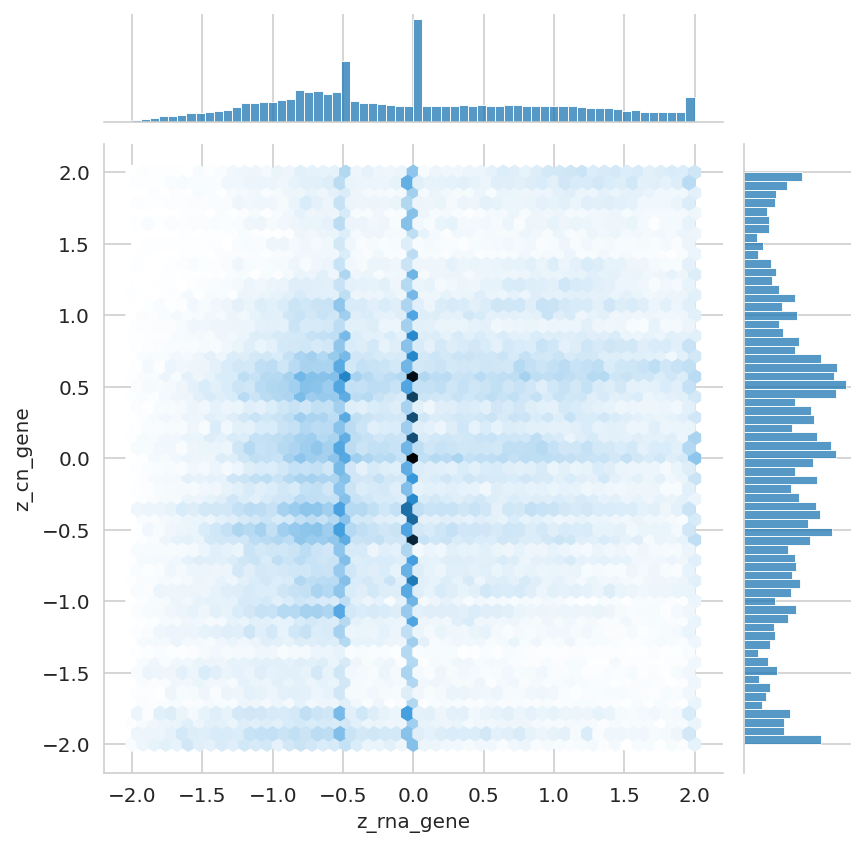

In [40]:
plt_data = valid_prostate_data[
    ["depmap_id", "hugo_symbol", "z_rna_gene", "z_cn_gene"]
].drop_duplicates()
sns.jointplot(data=plt_data, x="z_rna_gene", y="z_cn_gene", kind="hex");

In [41]:
(
    prostate_post_summary.query("var_name == 'm'")
    .sort_values("mean")
    .reset_index()
    .pipe(extract_coords_param_names, names=["gene"], col="parameter")
    .pipe(head_tail, n=10)
)

index     parameter   mean     sd  hdi_5.5%  hdi_94.5%  mcse_mean  \
0      62148      m[KIF11] -0.189  0.034    -0.242     -0.136      0.001   
1      67016        m[RAN] -0.185  0.034    -0.238     -0.129      0.001   
2      61350      m[HSPE1] -0.184  0.034    -0.237     -0.129      0.001   
3      67573      m[RPL12] -0.177  0.031    -0.227     -0.129      0.000   
4      58907       m[EEF2] -0.174  0.030    -0.223     -0.129      0.000   
5      67618       m[RPL9] -0.172  0.031    -0.224     -0.123      0.000   
6      66205     m[POLR2L] -0.169  0.031    -0.221     -0.124      0.000   
7      58802       m[DUX4] -0.168  0.031    -0.216     -0.119      0.001   
8      67610       m[RPL4] -0.167  0.031    -0.220     -0.120      0.000   
9      67658      m[RPS28] -0.167  0.031    -0.217     -0.118      0.000   
18109  63472      m[MGST1]  0.052  0.023     0.015      0.088      0.000   
18110  56441     m[CACNG7]  0.052  0.023     0.015      0.088      0.000   
18111  56996      m[CDH15]  0.053  0.028     0.010      0.097      0.001   
18112  59165      m[EPHA2]  0.053  0.026     0.013      0.095      0.001   
18113  62394   m[KRTAP1-3]  0.053  0.026     0.011      0.095      0.000   
18114  70435  m[TMPRSS11F]  0.055  0.024     0.018      0.095      0.000   
18115  61125   m[HLA-DQB1]  0.056  0.024     0.019      0.094      0.000   
18116  72261     m[ZNF611]  0.060  0.024     0.022      0.097      0.000   
18117  61093   m[HIST1H4I]  0.063  0.024     0.025      0.099      0.000   
18118  64327        m[NF2]  0.065  0.028     0.020      0.109      0.001   

       mcse_sd  ess_bulk  ess_tail  r_hat var_name       gene  
0          0.0    2575.0    2961.0    1.0        m      KIF11  
1          0.0    3368.0    3039.0    1.0        m        RAN  
2          0.0    3113.0    3355.0    1.0        m      HSPE1  
3          0.0    5074.0    3474.0    1.0        m      RPL12  
4          0.0    4222.0    3480.0    1.0        m       EEF2  
5          0.0    4344.0    3517.0    1.0        m       RPL9  
6          0.0    4958.0    3050.0    1.0        m     POLR2L  
7          0.0    3870.0    3173.0    1.0        m       DUX4  
8          0.0    4068.0    3319.0    1.0        m       RPL4  
9          0.0    3920.0    2935.0    1.0        m      RPS28  
18109      0.0    5466.0    2881.0    1.0        m      MGST1  
18110      0.0    5578.0    2965.0    1.0        m     CACNG7  
18111      0.0    1654.0    2428.0    1.0        m      CDH15  
18112      0.0    2484.0    2812.0    1.0        m      EPHA2  
18113      0.0    6096.0    3033.0    1.0        m   KRTAP1-3  
18114      0.0    4554.0    3390.0    1.0        m  TMPRSS11F  
18115      0.0    5360.0    3094.0    1.0        m   HLA-DQB1  
18116      0.0    4899.0    2368.0    1.0        m     ZNF611  
18117      0.0    5310.0    3017.0    1.0        m   HIST1H4I  
18118      0.0    2366.0    2132.0    1.0        m        NF2

In [42]:
prostate_data.query("hugo_symbol == 'RAN'")[
    ["depmap_id", "is_mutated"]
].drop_duplicates()

depmap_id  is_mutated
9540    ACH-000115       False
80602   ACH-000977       False
151664  ACH-001453       False
222726  ACH-001627       False
293788  ACH-001648       False

In [43]:
gene_RAN_idx = valid_prostate_data["hugo_symbol"] == "RAN"
prostate_mdl_data.is_mutated[gene_RAN_idx]

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
      dtype=int32)

In [44]:
RAN_gene_code = np.where(np.asarray(trace.posterior.coords["gene"]) == "RAN")[0][0]
RAN_gene_code

12642

In [45]:
RAN_idx = prostate_mdl_data.gene_idx == RAN_gene_code
prostate_mdl_data.is_mutated[RAN_idx]

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
      dtype=int32)

In [46]:
genes_chol_cov_dims = np.asarray(["mu_d", "h", "k", "m"])
genes_chol_cov_corr_post = (
    az.summary(trace, var_names=["genes_chol_cov_corr"])
    .pipe(extract_coords_param_names, names=["d1", "d2"])
    .assign(
        var_name1=lambda d: genes_chol_cov_dims[d["d1"].astype(int)],
        var_name2=lambda d: genes_chol_cov_dims[d["d2"].astype(int)],
    )
    .reset_index(drop=True)
)
genes_chol_cov_corr_post

/home/jc604/.conda/envs/speclet/lib/python3.10/site-packages/arviz/stats/diagnostics.py:586: RuntimeWarning: invalid value encountered in double_scalars
  (between_chain_variance / within_chain_variance + num_samples - 1) / (num_samples)


mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  ess_tail  \
0   1.000  0.000   1.000    1.000      0.000    0.000    4000.0    4000.0   
1   0.041  0.020   0.004    0.079      0.000    0.000    3613.0    3681.0   
2  -0.676  0.022  -0.718   -0.637      0.001    0.001     584.0     997.0   
3   0.852  0.073   0.724    0.982      0.003    0.002     770.0    1091.0   
4   0.041  0.020   0.004    0.079      0.000    0.000    3613.0    3681.0   
5   1.000  0.000   1.000    1.000      0.000    0.000    4137.0    4000.0   
6   0.331  0.043   0.254    0.415      0.002    0.002     414.0     901.0   
7  -0.030  0.155  -0.318    0.257      0.005    0.003    1001.0    1743.0   
8  -0.676  0.022  -0.718   -0.637      0.001    0.001     584.0     997.0   
9   0.331  0.043   0.254    0.415      0.002    0.002     414.0     901.0   
10  1.000  0.000   1.000    1.000      0.000    0.000    4037.0    4000.0   
11 -0.591  0.136  -0.844   -0.341      0.005    0.004     669.0    1283.0   
12  0.852  0.073   0.724    0.982      0.003    0.002     770.0    1091.0   
13 -0.030  0.155  -0.318    0.257      0.005    0.003    1001.0    1743.0   
14 -0.591  0.136  -0.844   -0.341      0.005    0.004     669.0    1283.0   
15  1.000  0.000   1.000    1.000      0.000    0.000    3986.0    3625.0   

    r_hat d1 d2 var_name1 var_name2  
0     NaN  0  0      mu_d      mu_d  
1    1.00  0  1      mu_d         h  
2    1.01  0  2      mu_d         k  
3    1.01  0  3      mu_d         m  
4    1.00  1  0         h      mu_d  
5    1.00  1  1         h         h  
6    1.01  1  2         h         k  
7    1.00  1  3         h         m  
8    1.01  2  0         k      mu_d  
9    1.01  2  1         k         h  
10   1.00  2  2         k         k  
11   1.01  2  3         k         m  
12   1.01  3  0         m      mu_d  
13   1.00  3  1         m         h  
14   1.01  3  2         m         k  
15   1.00  3  3         m         m

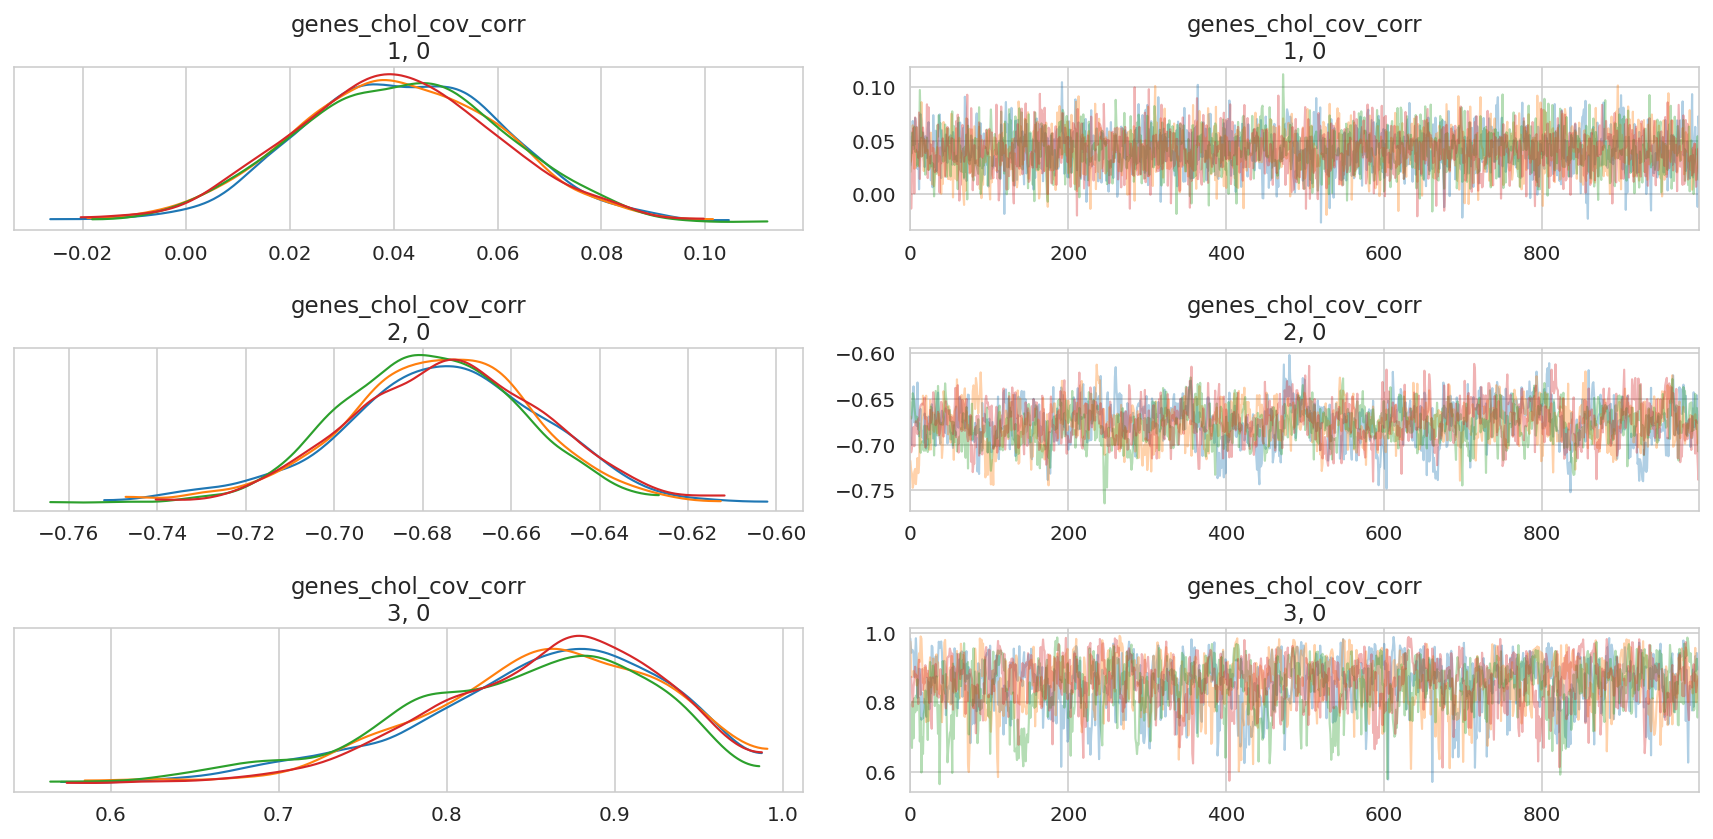

In [47]:
az.plot_trace(
    trace,
    var_names="genes_chol_cov_corr",
    coords={"genes_chol_cov_corr_dim_0": [1, 2, 3], "genes_chol_cov_corr_dim_1": [0]},
    combined=False,
    compact=False,
)
plt.tight_layout()
plt.show()

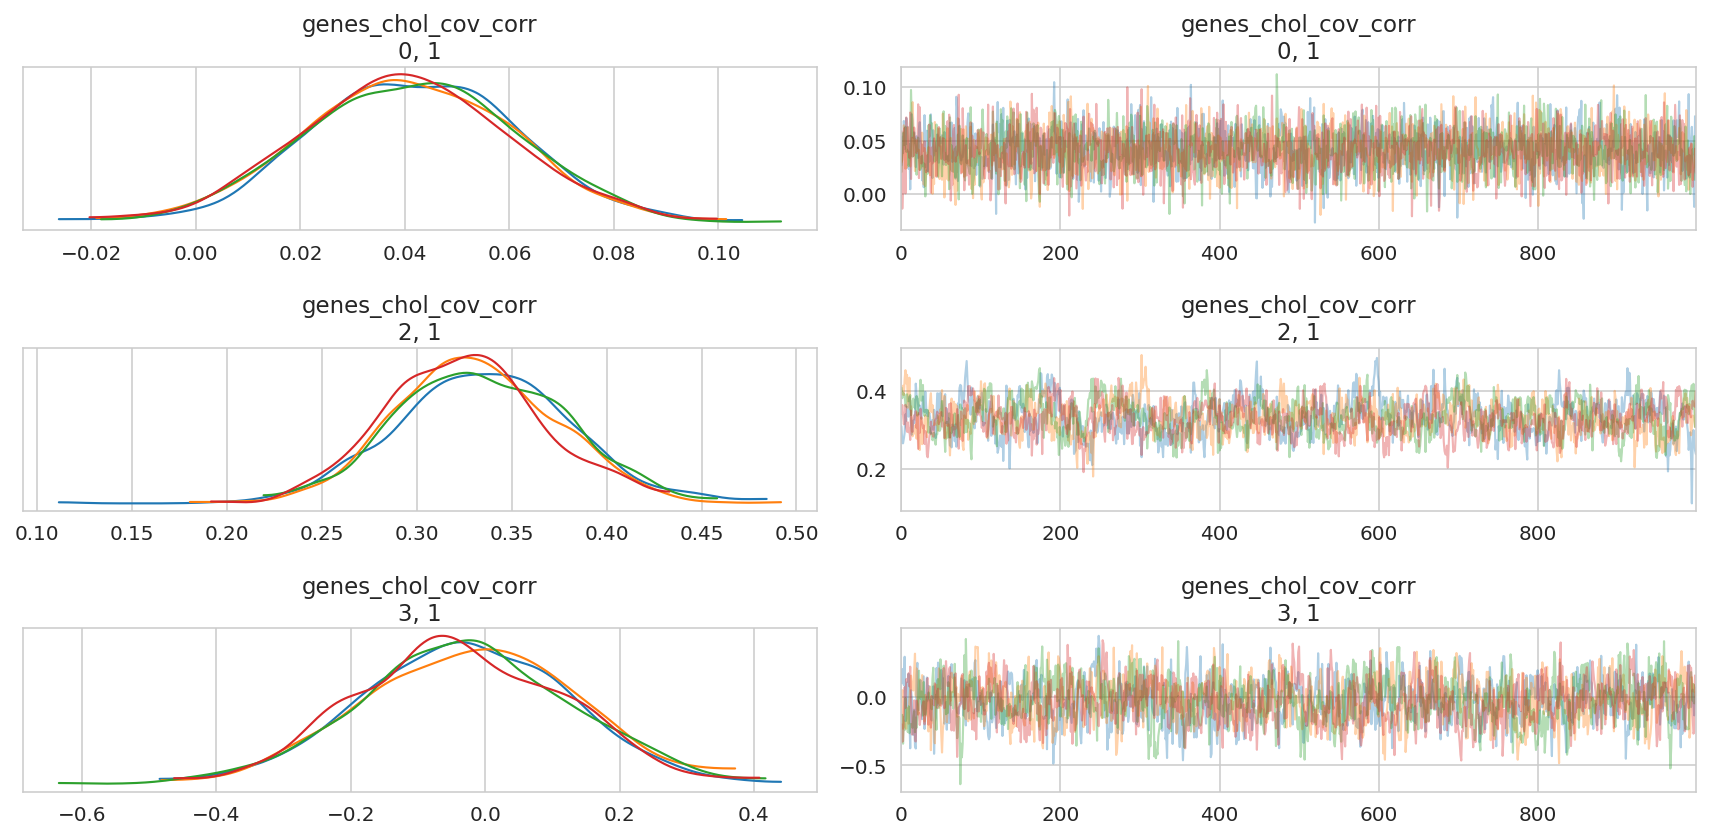

In [48]:
az.plot_trace(
    trace,
    var_names="genes_chol_cov_corr",
    coords={"genes_chol_cov_corr_dim_0": [0, 2, 3], "genes_chol_cov_corr_dim_1": [1]},
    combined=False,
    compact=False,
)
plt.tight_layout()
plt.show()

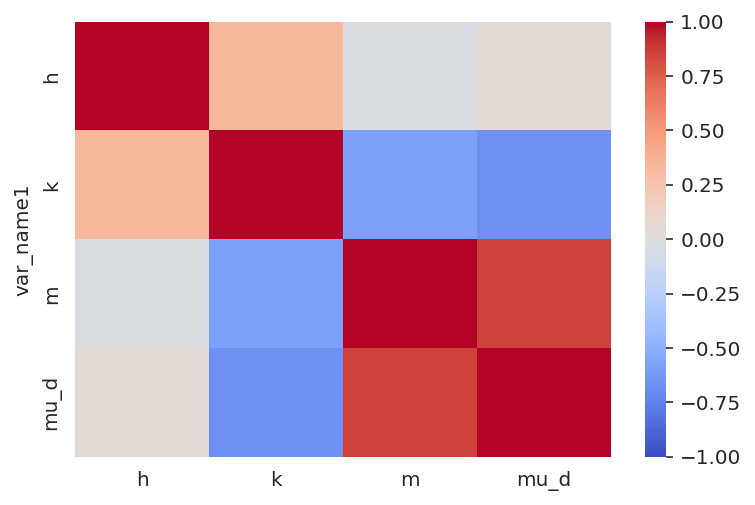

In [49]:
plt_data = genes_chol_cov_corr_post.pivot_wider(
    "var_name1", names_from="var_name2", values_from="mean"
).set_index("var_name1")
sns.heatmap(data=plt_data, vmin=-1, vmax=1, cmap="coolwarm")
plt.show()

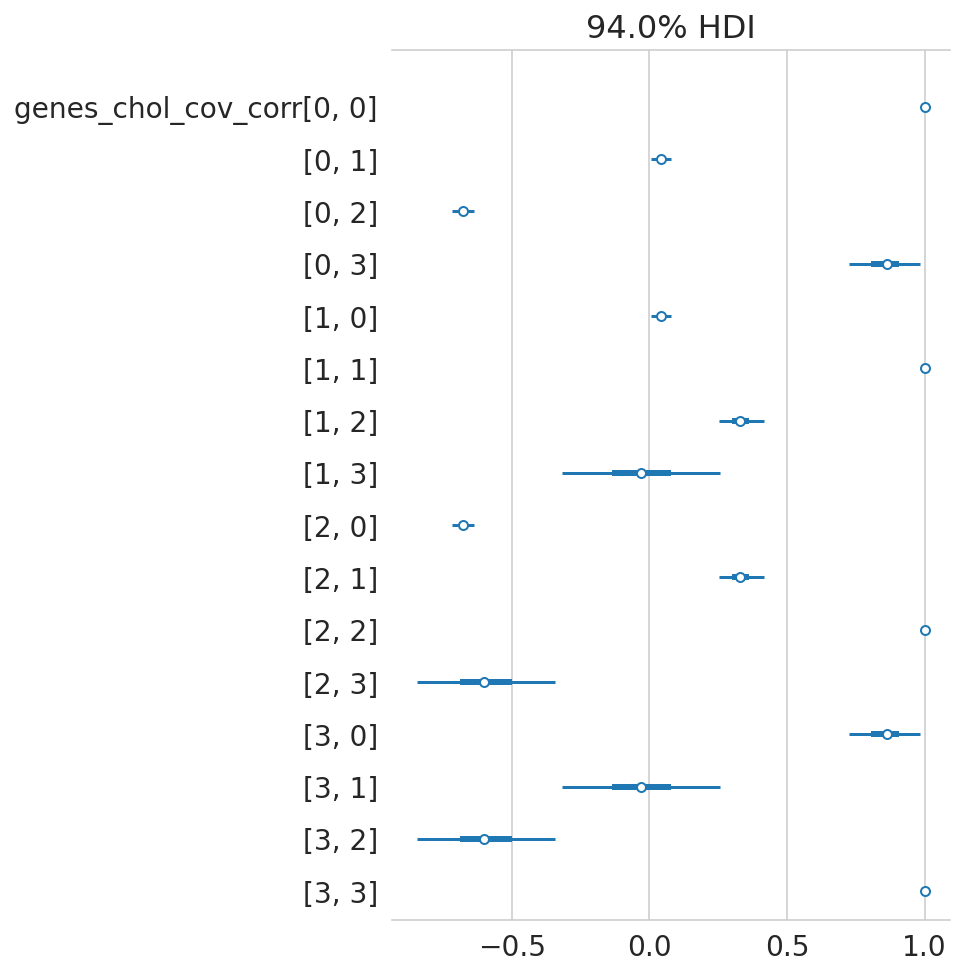

In [50]:
az.plot_forest(trace, var_names=["genes_chol_cov_corr"], combined=True, figsize=(5, 8))
plt.show()

In [51]:
cells_chol_cov_dims = np.asarray(["b", "f"])
cells_chol_cov_corr_post = (
    az.summary(trace, var_names=["celllines_chol_cov_corr"])
    .pipe(extract_coords_param_names, names=["d1", "d2"])
    .assign(
        var_name1=lambda d: cells_chol_cov_dims[d["d1"].astype(int)],
        var_name2=lambda d: cells_chol_cov_dims[d["d2"].astype(int)],
    )
    .reset_index(drop=True)
)
cells_chol_cov_corr_post

/home/jc604/.conda/envs/speclet/lib/python3.10/site-packages/arviz/stats/diagnostics.py:586: RuntimeWarning: invalid value encountered in double_scalars
  (between_chain_variance / within_chain_variance + num_samples - 1) / (num_samples)


mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  ess_tail  \
0  1.000  0.000    1.00    1.000      0.000    0.000    4000.0    4000.0   
1 -0.661  0.272   -0.99   -0.141      0.008    0.006    1199.0    1702.0   
2 -0.661  0.272   -0.99   -0.141      0.008    0.006    1199.0    1702.0   
3  1.000  0.000    1.00    1.000      0.000    0.000    4015.0    4000.0   

   r_hat d1 d2 var_name1 var_name2  
0    NaN  0  0         b         b  
1    1.0  0  1         b         f  
2    1.0  1  0         f         b  
3    1.0  1  1         f         f

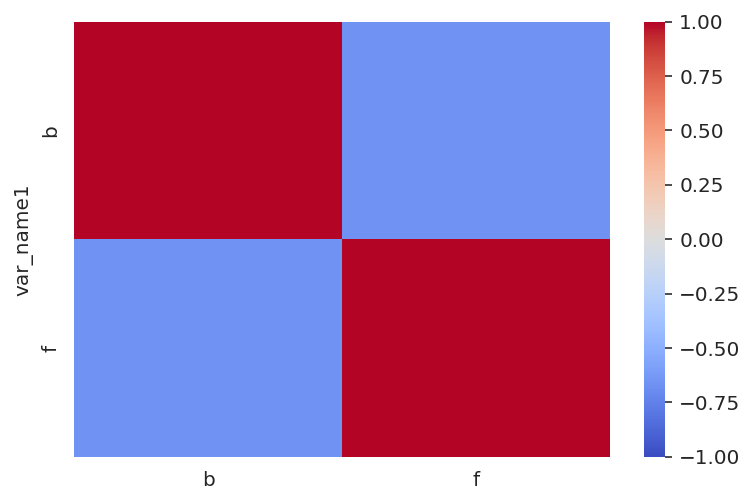

In [52]:
plt_data = cells_chol_cov_corr_post.pivot_wider(
    "var_name1", names_from="var_name2", values_from="mean"
).set_index("var_name1")
sns.heatmap(data=plt_data, vmin=-1, vmax=1, cmap="coolwarm")
plt.show()

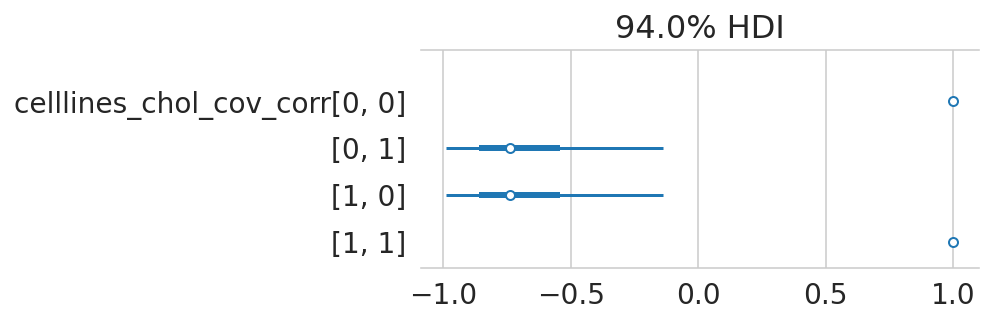

In [53]:
az.plot_forest(
    trace, var_names=["celllines_chol_cov_corr"], combined=True, figsize=(5, 2)
)
plt.show()

In [54]:
def is_all_mut(df: pd.DataFrame) -> bool:
    return df["is_mutated"].all()


valid_prostate_data.copy().groupby("hugo_symbol").apply(is_all_mut).reset_index(
    drop=False
).rename(columns={0: "is_all_mutated"}).query("is_all_mutated")

Empty DataFrame
Columns: [hugo_symbol, is_all_mutated]
Index: []

In [55]:
mut_genes = valid_prostate_data.query("is_mutated")["hugo_symbol"].unique()
print(f"number of genes with a mutation: {len(mut_genes)}")

mut_gene_hits = (
    prostate_post_summary.query("var_name == 'm'")
    .reset_index(drop=True)
    .pipe(extract_coords_param_names, names=["gene"], col="parameter")
    .filter_column_isin("gene", mut_genes)
    .sort_values("mean")
    .reset_index(drop=True)
    .pipe(head_tail, n=10)
)
mut_gene_hits

number of genes with a mutation: 3493


parameter   mean     sd  hdi_5.5%  hdi_94.5%  mcse_mean  mcse_sd  \
0       m[KIF11] -0.189  0.034    -0.242     -0.136      0.001      0.0   
1        m[EEF2] -0.174  0.030    -0.223     -0.129      0.000      0.0   
2       m[SPC24] -0.165  0.030    -0.210     -0.115      0.000      0.0   
3        m[SARS] -0.161  0.029    -0.209     -0.118      0.000      0.0   
4       m[THAP1] -0.161  0.031    -0.210     -0.114      0.000      0.0   
5       m[ESPL1] -0.155  0.029    -0.200     -0.110      0.000      0.0   
6        m[RPS8] -0.154  0.029    -0.196     -0.107      0.000      0.0   
7        m[UBA1] -0.152  0.028    -0.196     -0.106      0.000      0.0   
8     m[DYNC1H1] -0.151  0.029    -0.195     -0.104      0.000      0.0   
9      m[POLR3A] -0.147  0.028    -0.192     -0.102      0.000      0.0   
3483    m[GNGT1]  0.040  0.022     0.007      0.076      0.000      0.0   
3484  m[SLC22A1]  0.040  0.022     0.008      0.078      0.000      0.0   
3485     m[CCNF]  0.040  0.022     0.006      0.075      0.000      0.0   
3486   m[OR10J1]  0.041  0.022     0.005      0.075      0.000      0.0   
3487   m[NIPAL4]  0.041  0.023     0.004      0.076      0.000      0.0   
3488    m[BMPR2]  0.042  0.023     0.006      0.079      0.000      0.0   
3489    m[SMCO3]  0.043  0.023     0.008      0.080      0.000      0.0   
3490    m[ESRP1]  0.043  0.024     0.006      0.080      0.000      0.0   
3491    m[CASP2]  0.044  0.022     0.009      0.080      0.000      0.0   
3492    m[VAMP5]  0.049  0.022     0.015      0.087      0.000      0.0   

      ess_bulk  ess_tail  r_hat var_name     gene  
0       2575.0    2961.0    1.0        m    KIF11  
1       4222.0    3480.0    1.0        m     EEF2  
2       3770.0    3255.0    1.0        m    SPC24  
3       4619.0    3061.0    1.0        m     SARS  
4       4881.0    3076.0    1.0        m    THAP1  
5       4961.0    3411.0    1.0        m    ESPL1  
6       4490.0    3196.0    1.0        m     RPS8  
7       4317.0    2798.0    1.0        m     UBA1  
8       4534.0    3296.0    1.0        m  DYNC1H1  
9       4139.0    2920.0    1.0        m   POLR3A  
3483    5453.0    2993.0    1.0        m    GNGT1  
3484    5619.0    3149.0    1.0        m  SLC22A1  
3485    4639.0    2690.0    1.0        m     CCNF  
3486    5187.0    2718.0    1.0        m   OR10J1  
3487    4983.0    2388.0    1.0        m   NIPAL4  
3488    4067.0    2454.0    1.0        m    BMPR2  
3489    3821.0    3093.0    1.0        m    SMCO3  
3490    3294.0    3264.0    1.0        m    ESRP1  
3491    5458.0    2806.0    1.0        m    CASP2  
3492    6036.0    3044.0    1.0        m    VAMP5

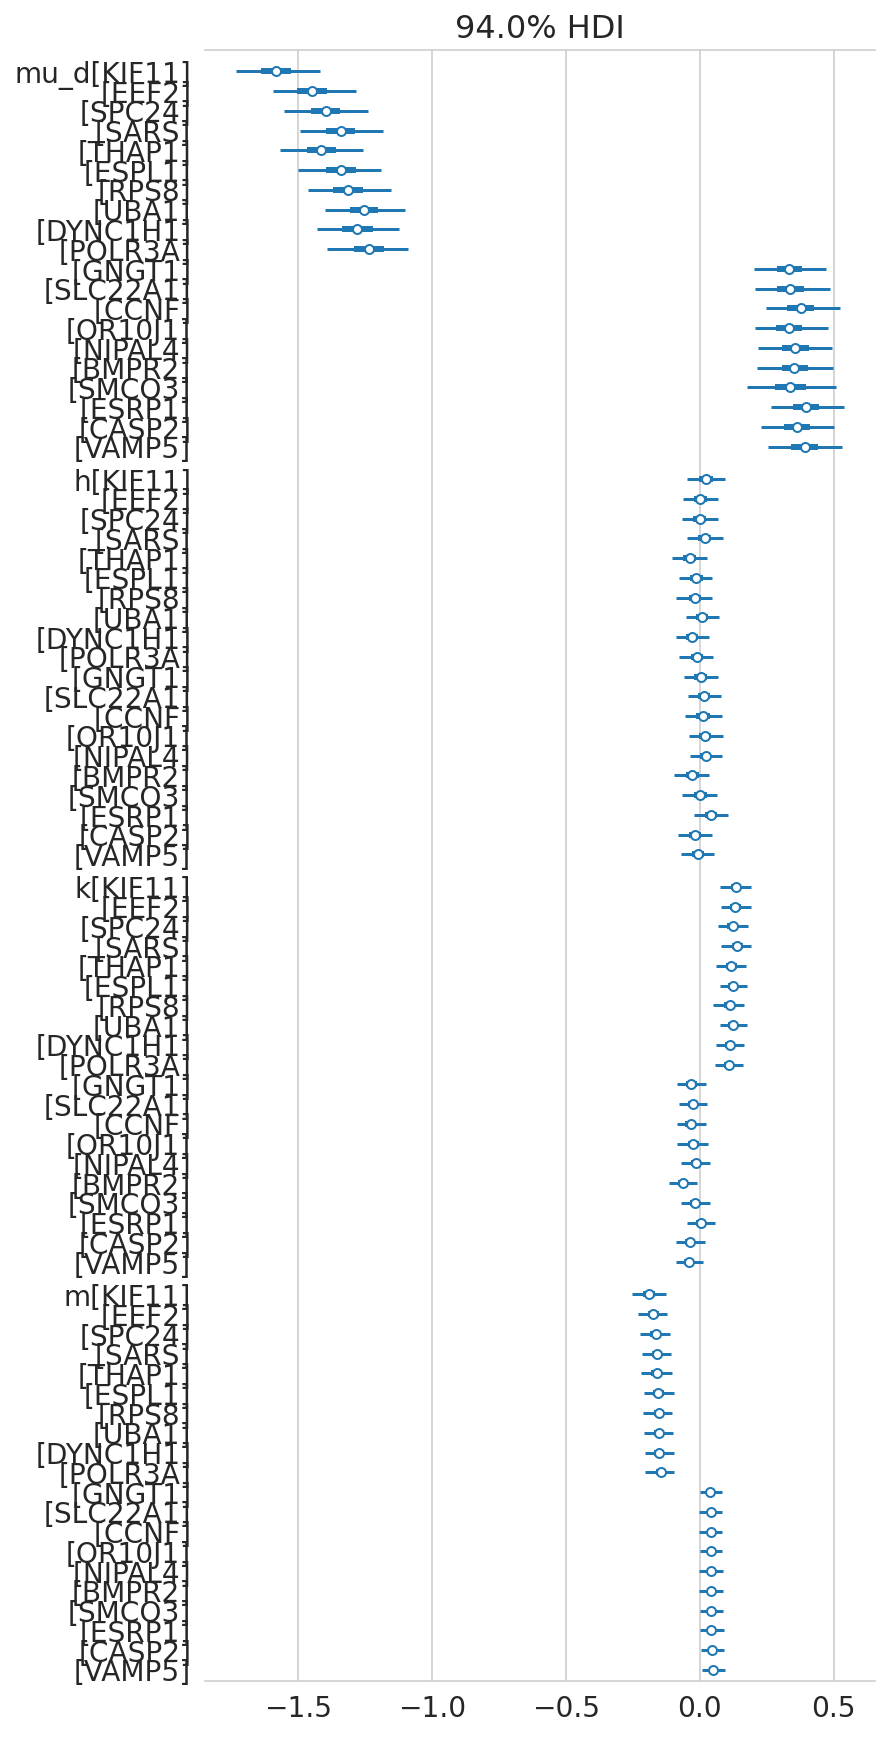

In [56]:
az.plot_forest(
    trace,
    var_names=["mu_d", "h", "k", "m"],
    coords={"gene": mut_gene_hits["gene"].tolist()},
    combined=True,
)
plt.show()

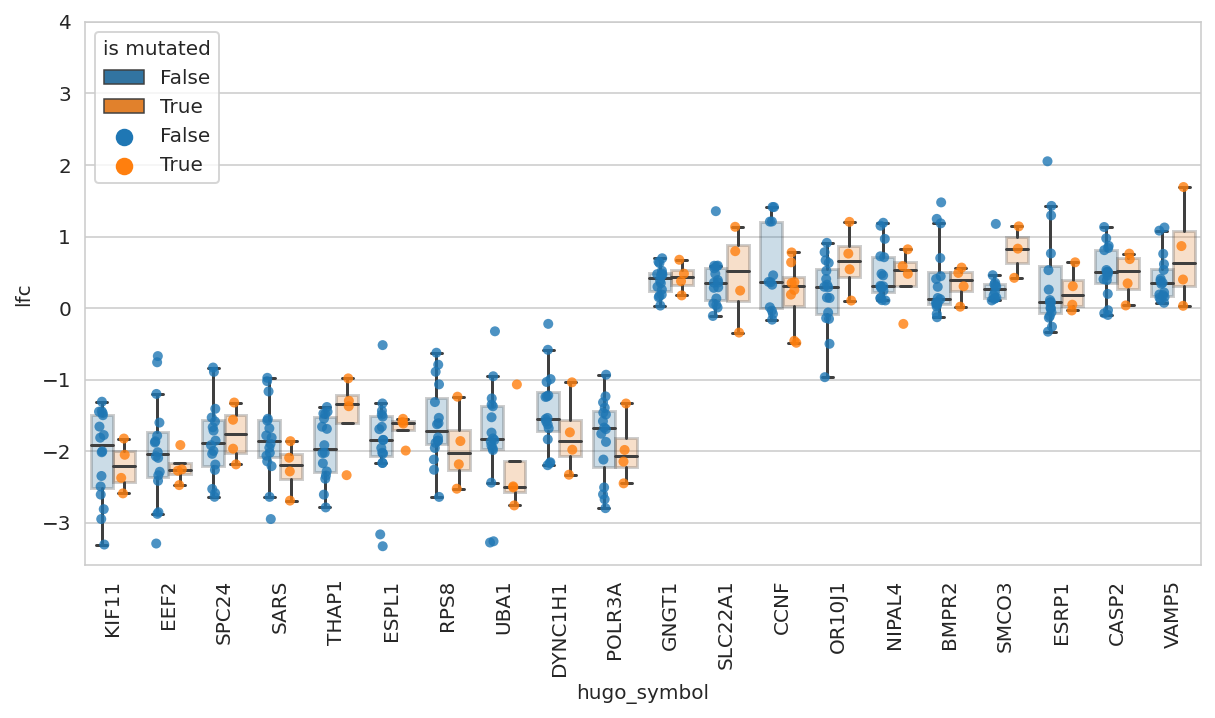

In [57]:
plot_data = valid_prostate_data.filter_column_isin(
    "hugo_symbol", mut_gene_hits["gene"]
).assign(
    hugo_symbol=lambda d: pd.Categorical(
        d["hugo_symbol"].tolist(), categories=mut_gene_hits["gene"], ordered=True
    )
)

_, ax = plt.subplots(figsize=(10, 5))
sns.boxplot(
    data=plot_data,
    x="hugo_symbol",
    y="lfc",
    hue="is_mutated",
    ax=ax,
    fliersize=0,
    boxprops={"alpha": 0.25},
)
sns.stripplot(
    data=plot_data,
    x="hugo_symbol",
    y="lfc",
    hue="is_mutated",
    dodge=True,
    alpha=0.8,
    ax=ax,
)
ax.tick_params("x", rotation=90)
ax.set_ylim(None, 4)
ax.legend(title="is mutated", loc="upper left")
plt.show()

count    355308.000000
mean         -0.101084
std           0.594996
min          -3.949914
25%          -0.331497
50%           0.016789
75%           0.276351
max           3.964780
Name: lfc, dtype: float64


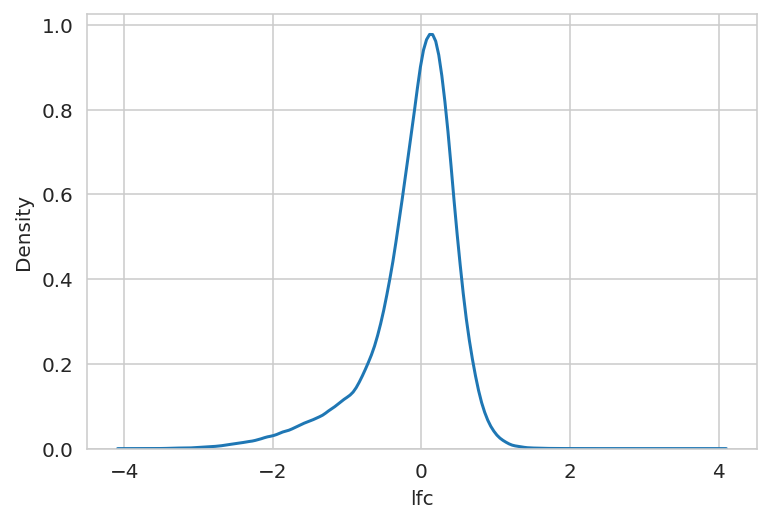

In [58]:
print(valid_prostate_data["lfc"].describe())
sns.kdeplot(valid_prostate_data["lfc"]);

In [59]:
top_gene_cn_hits = (
    prostate_post_summary.query("var_name == 'h'")
    .reset_index(drop=True)
    .pipe(extract_coords_param_names, names=["gene"], col="parameter")
    .sort_values("mean")
    .pipe(head_tail, n=5)
    .reset_index(drop=True)
)
top_gene_cn_hits

parameter   mean     sd  hdi_5.5%  hdi_94.5%  mcse_mean  mcse_sd  \
0   h[ATP1A1] -0.137  0.033    -0.190     -0.084      0.001      0.0   
1     h[DAP3] -0.115  0.033    -0.166     -0.060      0.000      0.0   
2    h[TRIT1] -0.110  0.034    -0.162     -0.056      0.000      0.0   
3     h[KLF5] -0.106  0.032    -0.156     -0.054      0.000      0.0   
4     h[NIP7] -0.106  0.033    -0.160     -0.054      0.001      0.0   
5    h[AIFM1]  0.101  0.033     0.047      0.152      0.000      0.0   
6     h[HCCS]  0.101  0.033     0.053      0.156      0.000      0.0   
7  h[NDUFB11]  0.102  0.033     0.048      0.154      0.000      0.0   
8     h[SOD1]  0.107  0.031     0.059      0.155      0.000      0.0   
9   h[MRPS11]  0.109  0.033     0.060      0.165      0.000      0.0   

   ess_bulk  ess_tail  r_hat var_name     gene  
0    4137.0    2725.0    1.0        h   ATP1A1  
1    4875.0    2585.0    1.0        h     DAP3  
2    6726.0    3325.0    1.0        h    TRIT1  
3    5392.0    3105.0    1.0        h     KLF5  
4    4216.0    2894.0    1.0        h     NIP7  
5    5975.0    3108.0    1.0        h    AIFM1  
6    5226.0    2890.0    1.0        h     HCCS  
7    5660.0    3190.0    1.0        h  NDUFB11  
8    5160.0    3238.0    1.0        h     SOD1  
9    5185.0    3074.0    1.0        h   MRPS11

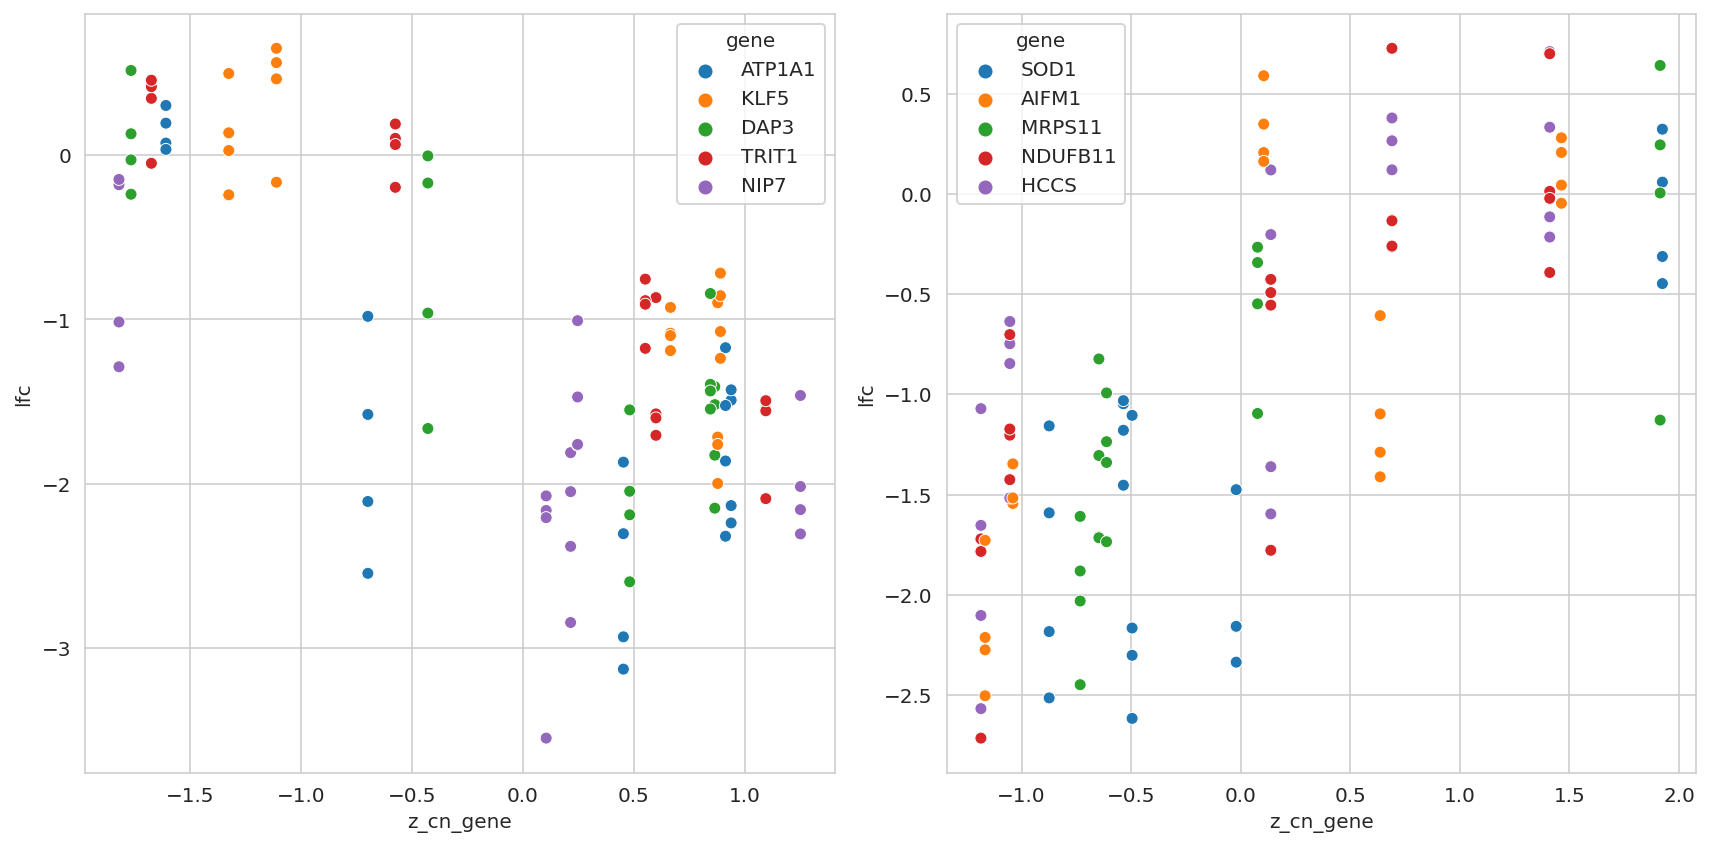

In [60]:
up_cn_genes = top_gene_cn_hits["gene"][:5]
down_cn_genes = top_gene_cn_hits["gene"][5:]


_, axes = plt.subplots(ncols=2, figsize=(12, 6))
for ax, direction, genes in zip(axes, ["up", "down"], [up_cn_genes, down_cn_genes]):
    plot_data = (
        valid_prostate_data.copy()
        .filter_column_isin("hugo_symbol", genes)
        .astype({"hugo_symbol": str})
        .query("lfc < 4")
    )
    sns.scatterplot(data=plot_data, x="z_cn_gene", y="lfc", hue="hugo_symbol", ax=ax)
    ax.legend(loc="best", title="gene")

plt.tight_layout()
plt.show()

In [61]:
top_gene_rna_hits = (
    prostate_post_summary.query("var_name == 'k'")
    .reset_index(drop=True)
    .pipe(extract_coords_param_names, names=["gene"], col="parameter")
    .sort_values("mean")
    .pipe(head_tail, n=5)
    .reset_index(drop=True)
)
top_gene_rna_hits

parameter   mean     sd  hdi_5.5%  hdi_94.5%  mcse_mean  mcse_sd  ess_bulk  \
0    k[NF2] -0.099  0.029    -0.147     -0.052      0.000      0.0    4930.0   
1  k[EP300] -0.098  0.031    -0.148     -0.049      0.001      0.0    2567.0   
2   k[ELOA] -0.064  0.027    -0.109     -0.021      0.000      0.0    6294.0   
3  k[BMPR2] -0.063  0.028    -0.108     -0.018      0.000      0.0    6400.0   
4  k[PRDM4] -0.062  0.027    -0.104     -0.018      0.000      0.0    5598.0   
5  k[RPS4X]  0.157  0.028     0.113      0.200      0.000      0.0    5286.0   
6  k[RPS11]  0.157  0.028     0.113      0.201      0.000      0.0    6561.0   
7   k[RPL4]  0.162  0.029     0.117      0.207      0.000      0.0    6108.0   
8   k[SOD1]  0.165  0.028     0.121      0.210      0.000      0.0    6114.0   
9   k[RPL9]  0.170  0.029     0.120      0.212      0.000      0.0    7020.0   

   ess_tail  r_hat var_name   gene  
0    2654.0    1.0        k    NF2  
1    2511.0    1.0        k  EP300  
2    2748.0    1.0        k   ELOA  
3    3000.0    1.0        k  BMPR2  
4    2781.0    1.0        k  PRDM4  
5    3065.0    1.0        k  RPS4X  
6    2941.0    1.0        k  RPS11  
7    2700.0    1.0        k   RPL4  
8    2754.0    1.0        k   SOD1  
9    3301.0    1.0        k   RPL9

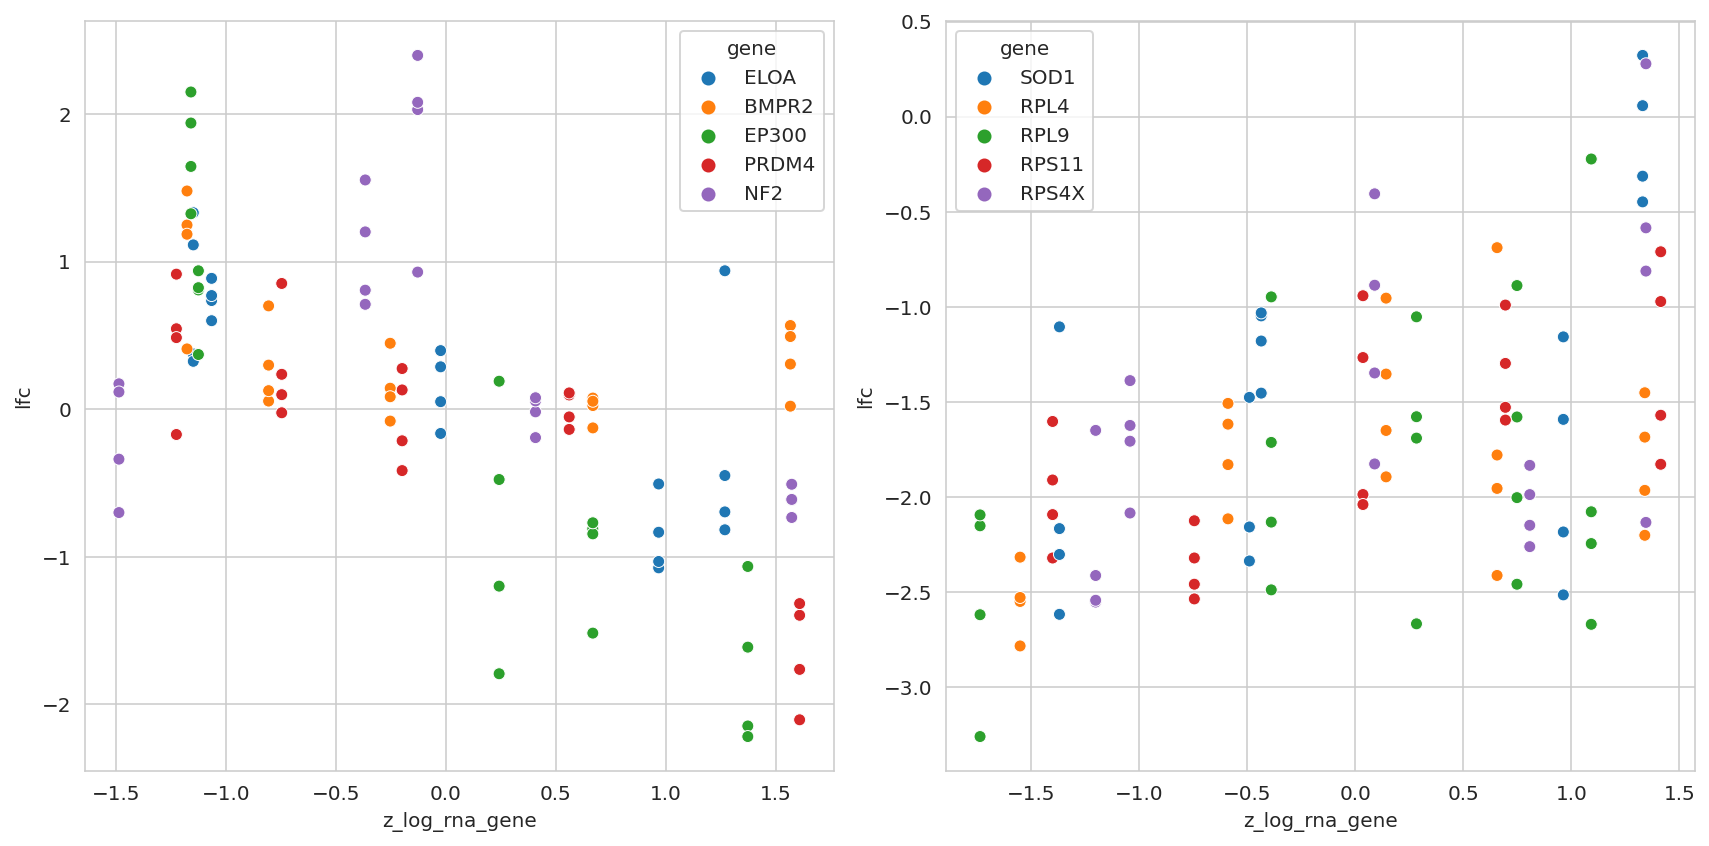

In [62]:
up_rna_genes = top_gene_rna_hits["gene"][:5]
down_rna_genes = top_gene_rna_hits["gene"][5:]


_, axes = plt.subplots(ncols=2, figsize=(12, 6))
for ax, direction, genes in zip(axes, ["up", "down"], [up_rna_genes, down_rna_genes]):
    plot_data = (
        valid_prostate_data.copy()
        .filter_column_isin("hugo_symbol", genes)
        .astype({"hugo_symbol": str})
        .query("lfc < 4")
    )
    sns.scatterplot(
        data=plot_data, x="z_log_rna_gene", y="lfc", hue="hugo_symbol", ax=ax
    )
    ax.legend(loc="best", title="gene")

plt.tight_layout()
plt.show()

In [63]:
n_examples = 100
n_chains, n_draws, n_data = trace.posterior_predictive["ct_final"].shape
ex_draws_idx = np.random.choice(
    np.arange(n_draws), size=n_examples // n_chains, replace=False
)
example_ppc_draws = trace.posterior_predictive["ct_final"][
    :, ex_draws_idx, :
].values.reshape(-1, n_data)
example_ppc_draws.shape

(100, 355308)

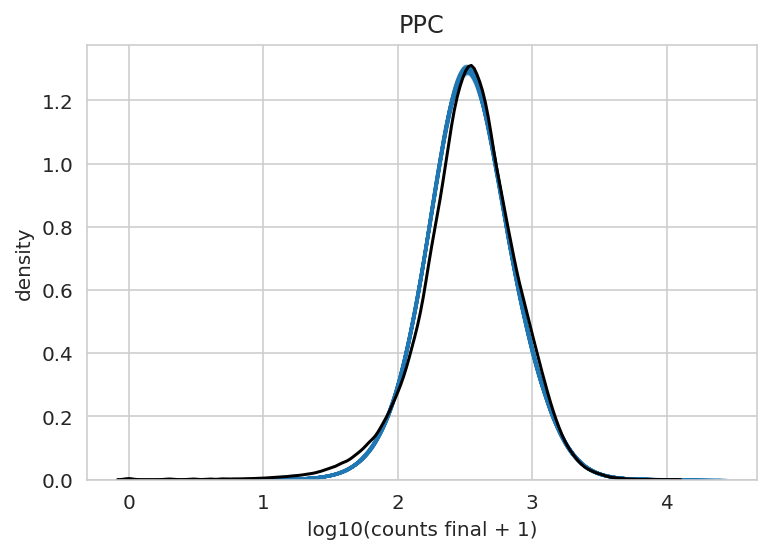

In [64]:
_, ax = plt.subplots(figsize=(6, 4))

for i in range(example_ppc_draws.shape[0]):
    sns.kdeplot(
        x=np.log10(example_ppc_draws[i, :] + 1), alpha=0.2, color="tab:blue", ax=ax
    )

sns.kdeplot(x=np.log10(valid_prostate_data["counts_final"] + 1), color="k", ax=ax)
ax.set_xlabel("log10(counts final + 1)")
ax.set_ylabel("density")
ax.set_title("PPC")
plt.show()

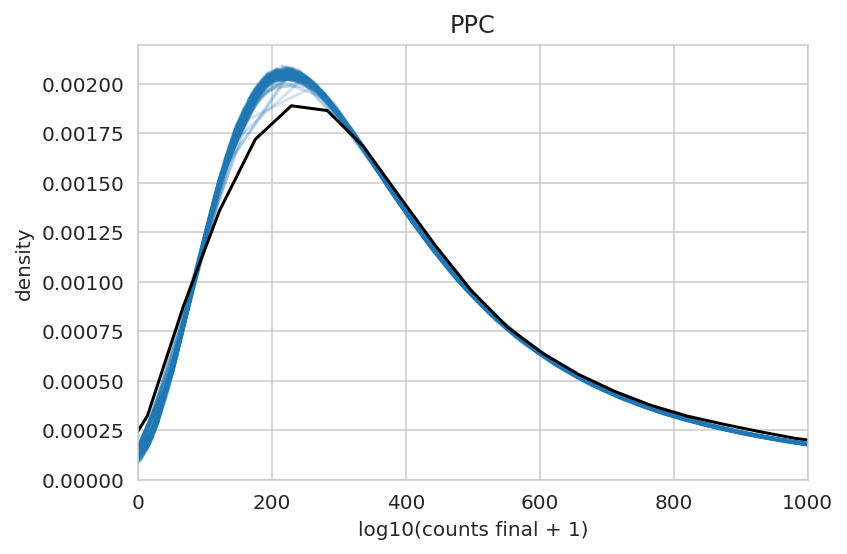

In [65]:
_, ax = plt.subplots(figsize=(6, 4))

for i in range(example_ppc_draws.shape[0]):
    sns.kdeplot(x=example_ppc_draws[i, :], alpha=0.2, color="tab:blue", ax=ax)

sns.kdeplot(x=valid_prostate_data["counts_final"], color="k", ax=ax)
ax.set_xlabel("log10(counts final + 1)")
ax.set_ylabel("density")
ax.set_title("PPC")
ax.set_xlim(0, 1000)
plt.show()

A little analysis of $w$ comutation variable.
All of the $\sigma_w$ were poorly sampled except for *ZFHX3*.

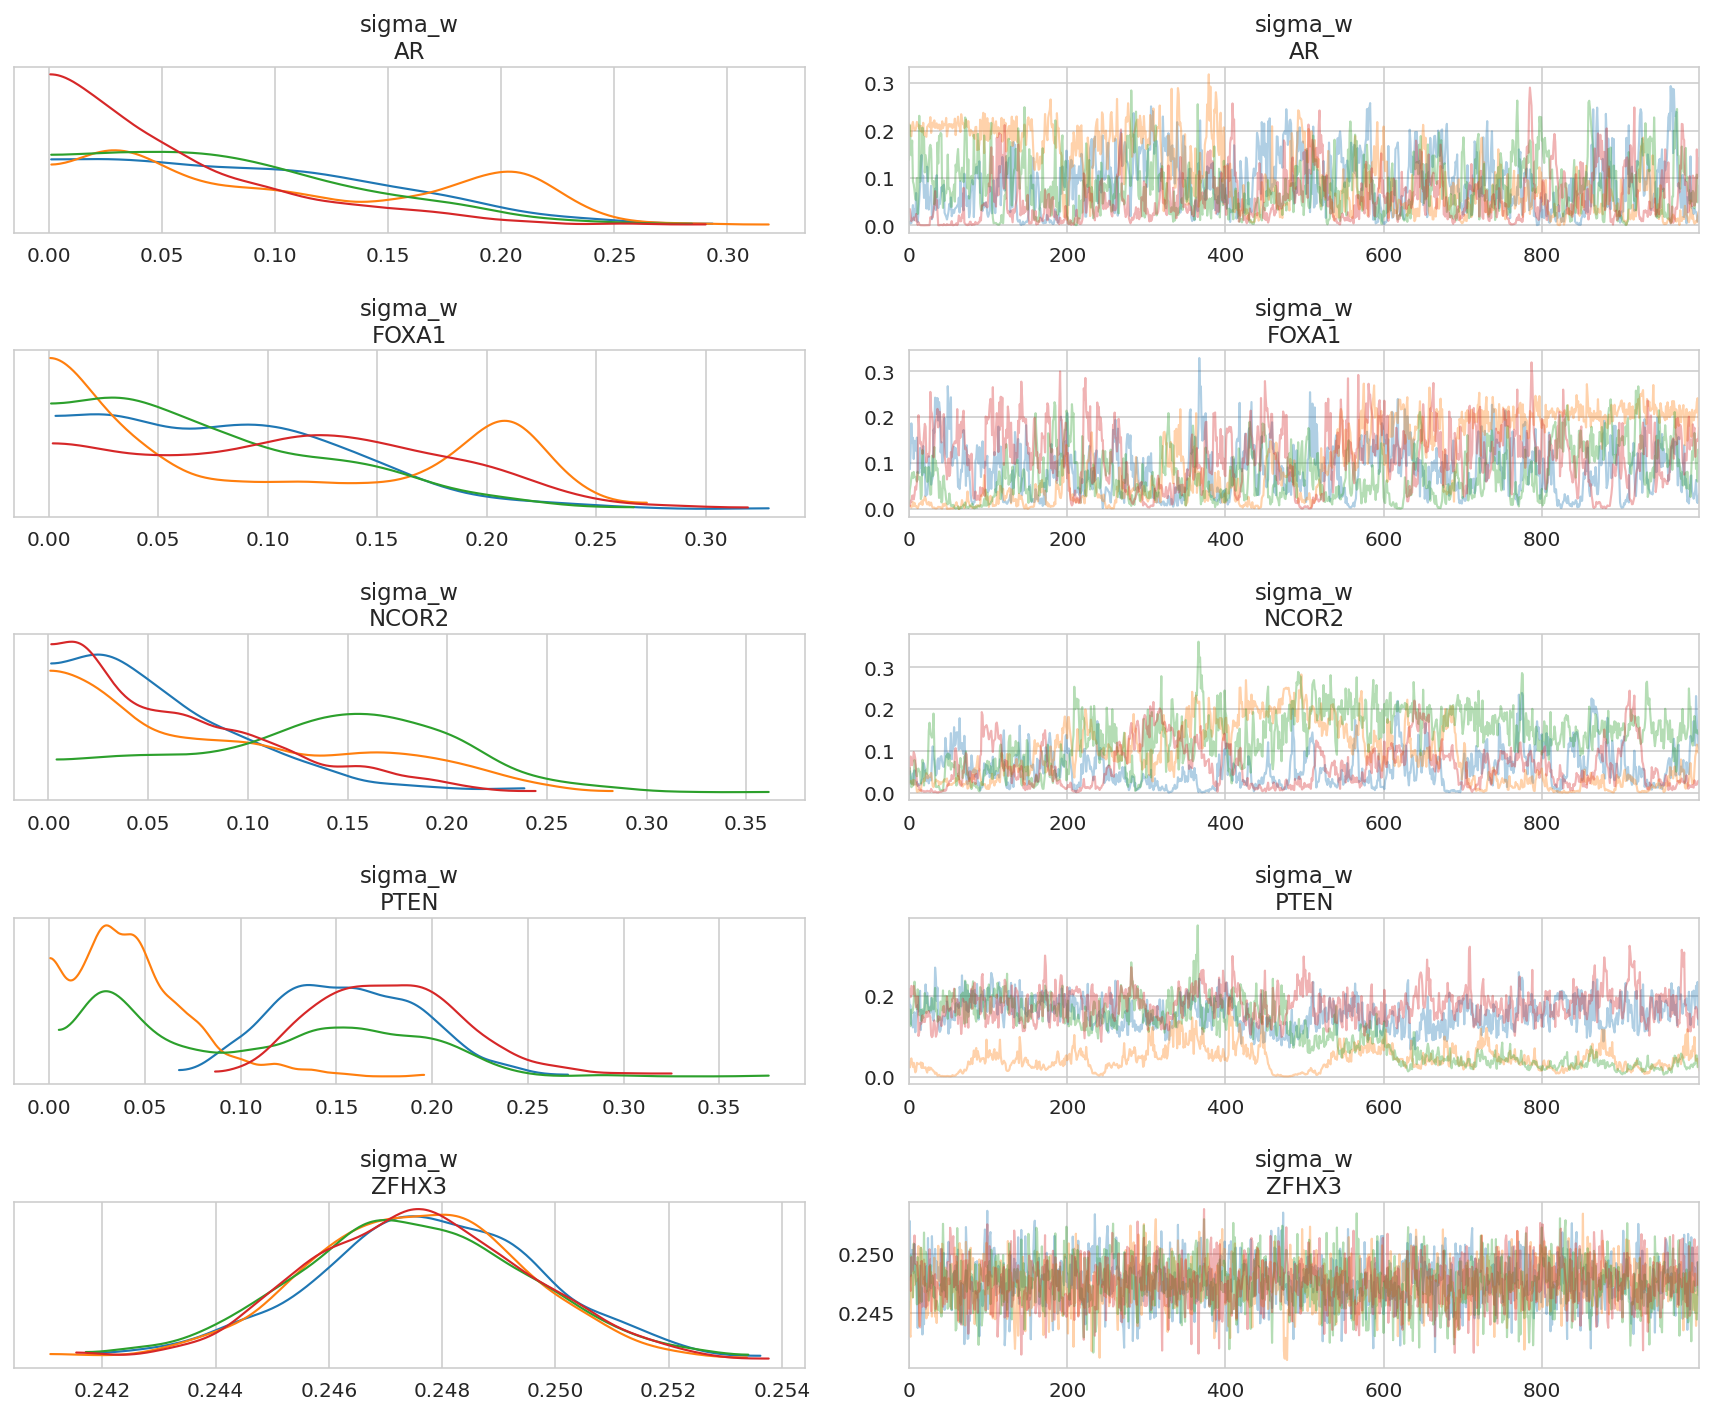

In [24]:
az.plot_trace(trace, var_names="sigma_w", compact=False)
plt.tight_layout()
plt.show()

In [ ]:
cancer_genes_mutations = (
    valid_prostate_data.filter_column_isin(
        "hugo_symbol", trace.posterior.coords["cancer_gene"].values
    )[["depmap_id", "hugo_symbol", "is_mutated"]]
    .drop_duplicates()
    .reset_index(drop=True)
    .sort_values(["depmap_id", "hugo_symbol"])
    .pivot_wider("hugo_symbol", names_from="depmap_id", values_from="is_mutated")
    .set_index("hugo_symbol")
)
cancer_genes_mutations

In [78]:
n_cells = 6
n_target_genes = 20
n_cancer_genes = 4
M = np.zeros((n_cancer_genes, n_cells))
M[:, 2] = 1
w = np.random.normal(0, 1, (n_target_genes, n_cancer_genes))
# np.dot(w, M)
M

array([[0., 0., 1., 0., 0., 0.],
       [0., 0., 1., 0., 0., 0.],
       [0., 0., 1., 0., 0., 0.],
       [0., 0., 1., 0., 0., 0.]])

In [26]:
w_post_summary = (
    prostate_post_summary.query("var_name == 'w'")
    .reset_index(drop=True)
    .pipe(
        extract_coords_param_names,
        names=["target_gene", "cancer_gene"],
        col="parameter",
    )
)
w_post_summary.head()

parameter   mean     sd  hdi_5.5%  hdi_94.5%  mcse_mean  mcse_sd  \
0     w[A1BG, AR]  0.002  0.091    -0.134      0.159      0.001    0.005   
1  w[A1BG, FOXA1]  0.007  0.100    -0.155      0.158      0.002    0.005   
2  w[A1BG, NCOR2]  0.002  0.093    -0.143      0.151      0.001    0.007   
3   w[A1BG, PTEN]  0.003  0.118    -0.193      0.191      0.002    0.013   
4  w[A1BG, ZFHX3] -0.029  0.133    -0.246      0.180      0.002    0.002   

   ess_bulk  ess_tail  r_hat var_name target_gene cancer_gene  
0    4661.0    1418.0   1.05        w        A1BG          AR  
1    4274.0     781.0   1.06        w        A1BG       FOXA1  
2    5152.0     213.0   1.06        w        A1BG       NCOR2  
3    4025.0     409.0   1.21        w        A1BG        PTEN  
4    4153.0    3495.0   1.00        w        A1BG       ZFHX3

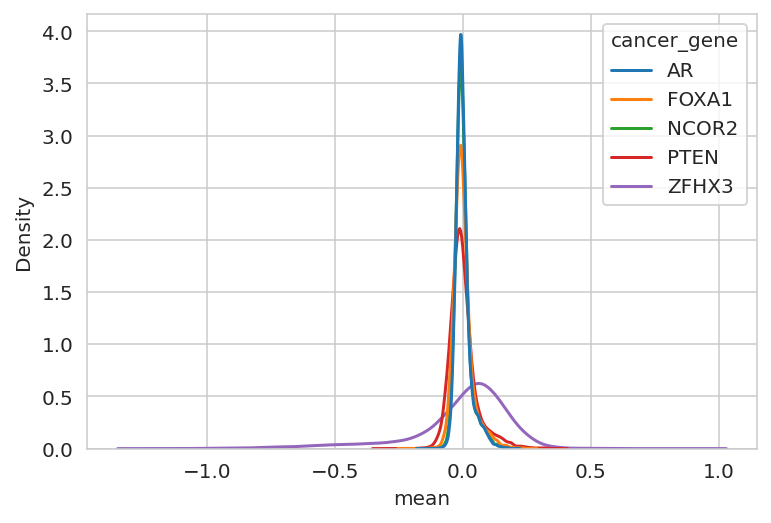

In [27]:
sns.kdeplot(data=w_post_summary, x="mean", hue="cancer_gene");

/home/jc604/.conda/envs/speclet/lib/python3.10/site-packages/seaborn/matrix.py:654: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)


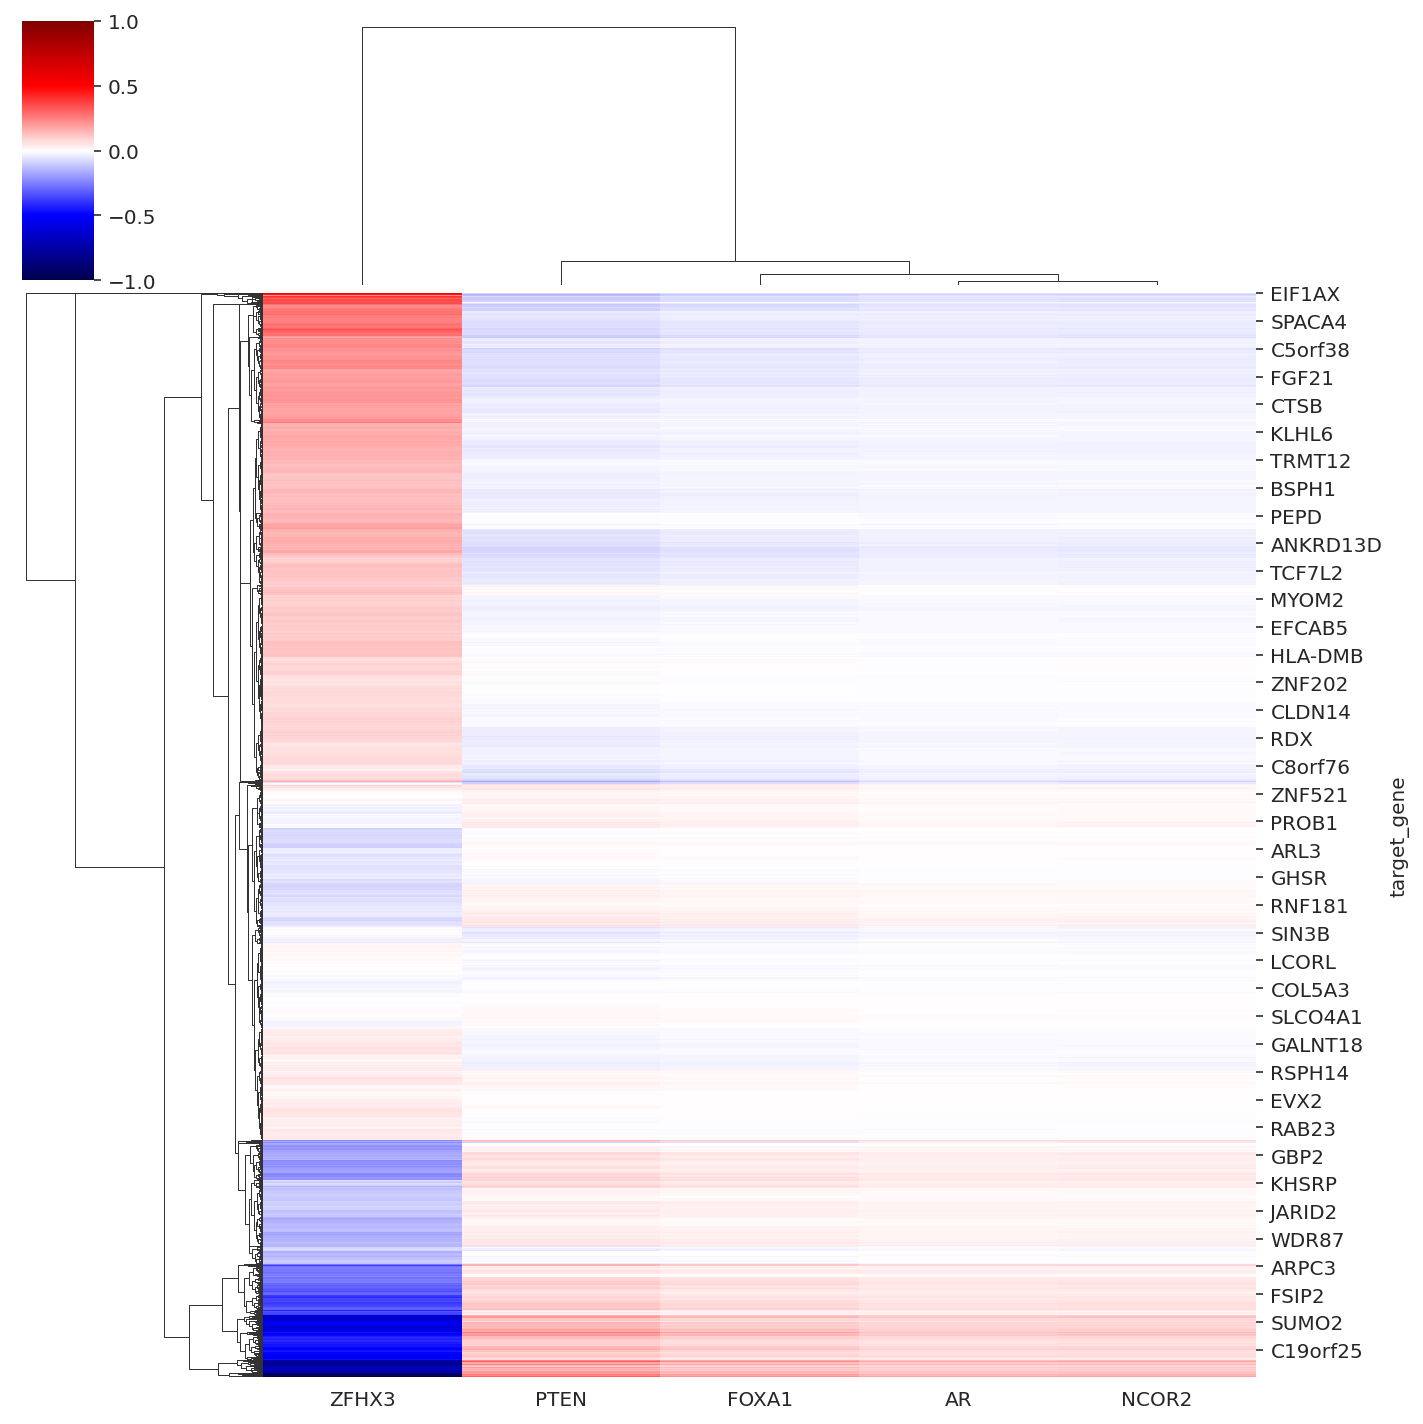

In [28]:
plt_df = w_post_summary.pivot_wider(
    "target_gene", names_from="cancer_gene", values_from="mean"
).set_index("target_gene")

sns.clustermap(plt_df, cmap="seismic", vmin=-1, vmax=1)

In [29]:
example_cancer_gene = "ZFHX3"
example_w = w_post_summary.query(f"cancer_gene == '{example_cancer_gene}'")

example_hits = (
    example_w.sort_values("mean").pipe(head_tail, n=10)["target_gene"].tolist()
)

In [30]:
cancer_gene_muts = list(
    prostate_data.query(f"hugo_symbol == '{example_cancer_gene}'")
    .query("is_mutated")["depmap_id"]
    .unique()
)

In [31]:
example_hit_data = (
    prostate_data.filter_column_isin("hugo_symbol", example_hits)
    .assign(cancer_gene_mut=lambda d: [cl in cancer_gene_muts for cl in d["depmap_id"]])
    .astype({"hugo_symbol": str})
)
example_hit_data["hugo_symbol"] = pd.Categorical(
    example_hit_data["hugo_symbol"], categories=example_hits, ordered=True
)

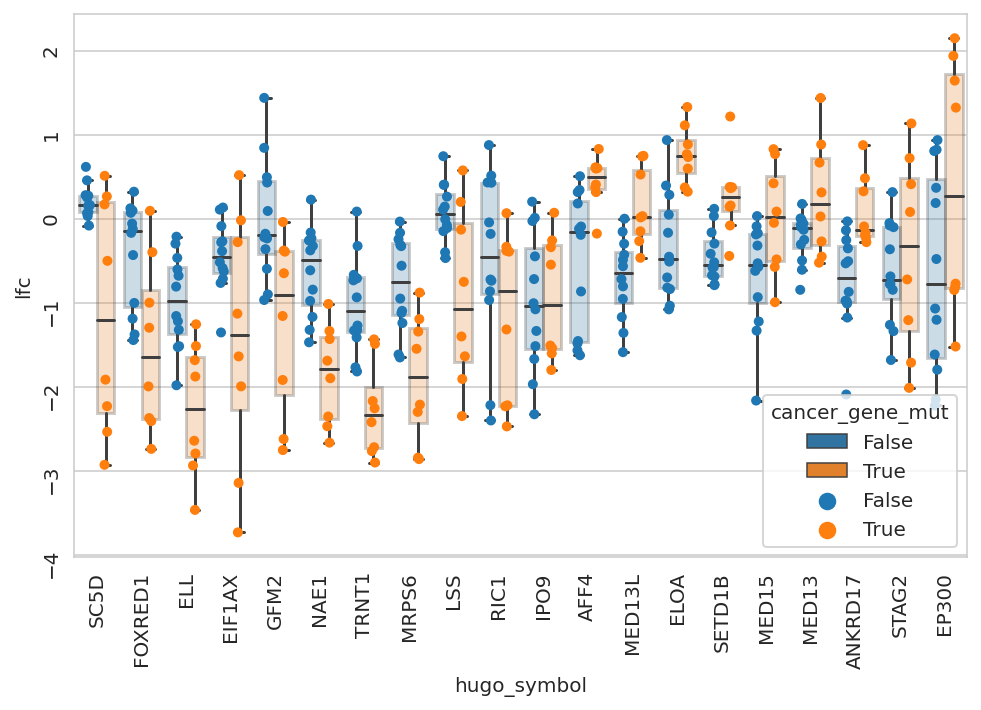

In [32]:
fig, ax = plt.subplots(figsize=(8, 5))
sns.boxplot(
    data=example_hit_data,
    x="hugo_symbol",
    y="lfc",
    hue="cancer_gene_mut",
    ax=ax,
    fliersize=0,
    boxprops={"alpha": 0.25},
)
sns.stripplot(
    data=example_hit_data,
    x="hugo_symbol",
    y="lfc",
    hue="cancer_gene_mut",
    dodge=True,
    ax=ax,
)
ax.tick_params(rotation=90)
plt.show()

---

## Session info

In [34]:
notebook_toc = time()
print(f"execution time: {(notebook_toc - notebook_tic) / 60:.2f} minutes")

execution time: 2.13 minutes


In [35]:
%load_ext watermark
%watermark -d -u -v -iv -b -h -m

Last updated: 2022-07-12

Python implementation: CPython
Python version       : 3.10.5
IPython version      : 8.4.0

Compiler    : GCC 10.3.0
OS          : Linux
Release     : 3.10.0-1160.45.1.el7.x86_64
Machine     : x86_64
Processor   : x86_64
CPU cores   : 32
Architecture: 64bit

Hostname: compute-a-17-83.o2.rc.hms.harvard.edu

Git branch: simplify

seaborn   : 0.11.2
numpy     : 1.23.0
pandas    : 1.4.3
arviz     : 0.12.1
matplotlib: 3.5.2

